<a href="https://colab.research.google.com/github/adatamahan/kunskapskontroll_2_deep_learning/blob/main/Kunskapskontroll_2_AstridHansen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FACE EXPRESSION CLASSIFIER <BR>

**KUNSKAPSKONTROLL_2 DEEP LEARNING <BR>
ASTRID HANSEN <BR>
ECUTBILDNING <BR>
MAJ 2024** <BR>

# TABLE OF CONTENT



1.   Introduction
2.   Importing the Packages
2.   Importing the data
2.   EDA
3.   Data Preprocessing <br>
        - Oversampling the Dataset<br>
        - Limited Dataset<br>
4.   Model 1
6.   Model 2
8.   Model 3     
10.  Model 4
11.  Tuner Search
12.  Best Model 1
12.  Best Model 2
12.  Best Model 3
12.  Model Evaluation
14.  Conclusions
13.  Reflections


# INTRODUCTION

The aim of this study is to make a deep learning model that can classify specified face expressions based on live image input. The dataset that will be used is tha Face Expression Recognition dataset from Kaggle. Specifications on the dataset will follow in the EDA section. <br><br>
The model training is divided into two sections. One that focuses on training a model on different preprocessed input. This includes image augumentation, rescaling and oversampling of the input features. The following models will be trained in this section: <br>
  **model_1**: baseline model inspired from the video https://www.youtube.com/watch?v=Bb4Wvl57LIk <br>
  **model_2**: model training with augumented and rescaled images <br>
  **model_3**: model_1 trained on oversampled dataset <br>
  **model_4**: model_2 trained on oversampled dataaset with augumentation and rescaling of the images<br><br>

  The next section focuses on the improving the performance by experimenting with the hyperparameters in the baseline model with the rescaling layer. The hyperparameters will be tested with the keras tuner function on a limited dataset. Afterwards the three best models found will be tested on the whole training set.<br><br>

In the last part of the code then the best models will be evaluated on the test set before continuing to the conclusions and reflections.


# 1. IMPORTING THE PACKAGES

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import random
import shutil
import io
import sys
import json

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling
from keras.models import Model,Sequential,load_model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)

In [3]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [4]:
import keras_tuner as kt
from kerastuner.engine.hyperparameters import HyperParameters


<ipython-input-4-a846a346e9ee>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters



# IMPORTING THE DATA <br>




As mentioned then the model will be trained on the Face Expression Recognition Dataset from Kaggle. It is downloaded to Google Colab via a Kaggle API in Google Drive. <br><br>
The data set consists of 48x48 pixel grayscale images of faces. The faces are more or less centered and occupies about the same amount of space in each image. The face expresses one of the following 7 categories Angry, Disgust, Fear, Happy, Sad, Surprise and Neutral. The dataset contains approximately 36K images where 80% are labelled as a train set and 20% as validation set.

In [6]:
# download via google drive kaggle API
!cp /content/drive/MyDrive/kaggle.json ~/kaggle.json

In [7]:
!pip show Kaggle

Name: kaggle
Version: 1.6.14
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: bleach, certifi, python-dateutil, python-slugify, requests, six, tqdm, urllib3
Required-by: 


In [8]:
!kaggle datasets download "jonathanoheix/face-expression-recognition-dataset"

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 98% 118M/121M [00:07<00:00, 20.8MB/s]
100% 121M/121M [00:07<00:00, 16.7MB/s]


In [9]:
!unzip -q '/content/face-expression-recognition-dataset.zip' -d '/content/'

# EDA

The data set consists of 3 folders, one with images, one with a train set and one with a validation set. This study will use the images from the train and the validation folders. The train and validation folders consists of 7 folders labelled with the names of the classes for the face expressions.

In [10]:
picture_size = 48
folder_path = "../content/images/"

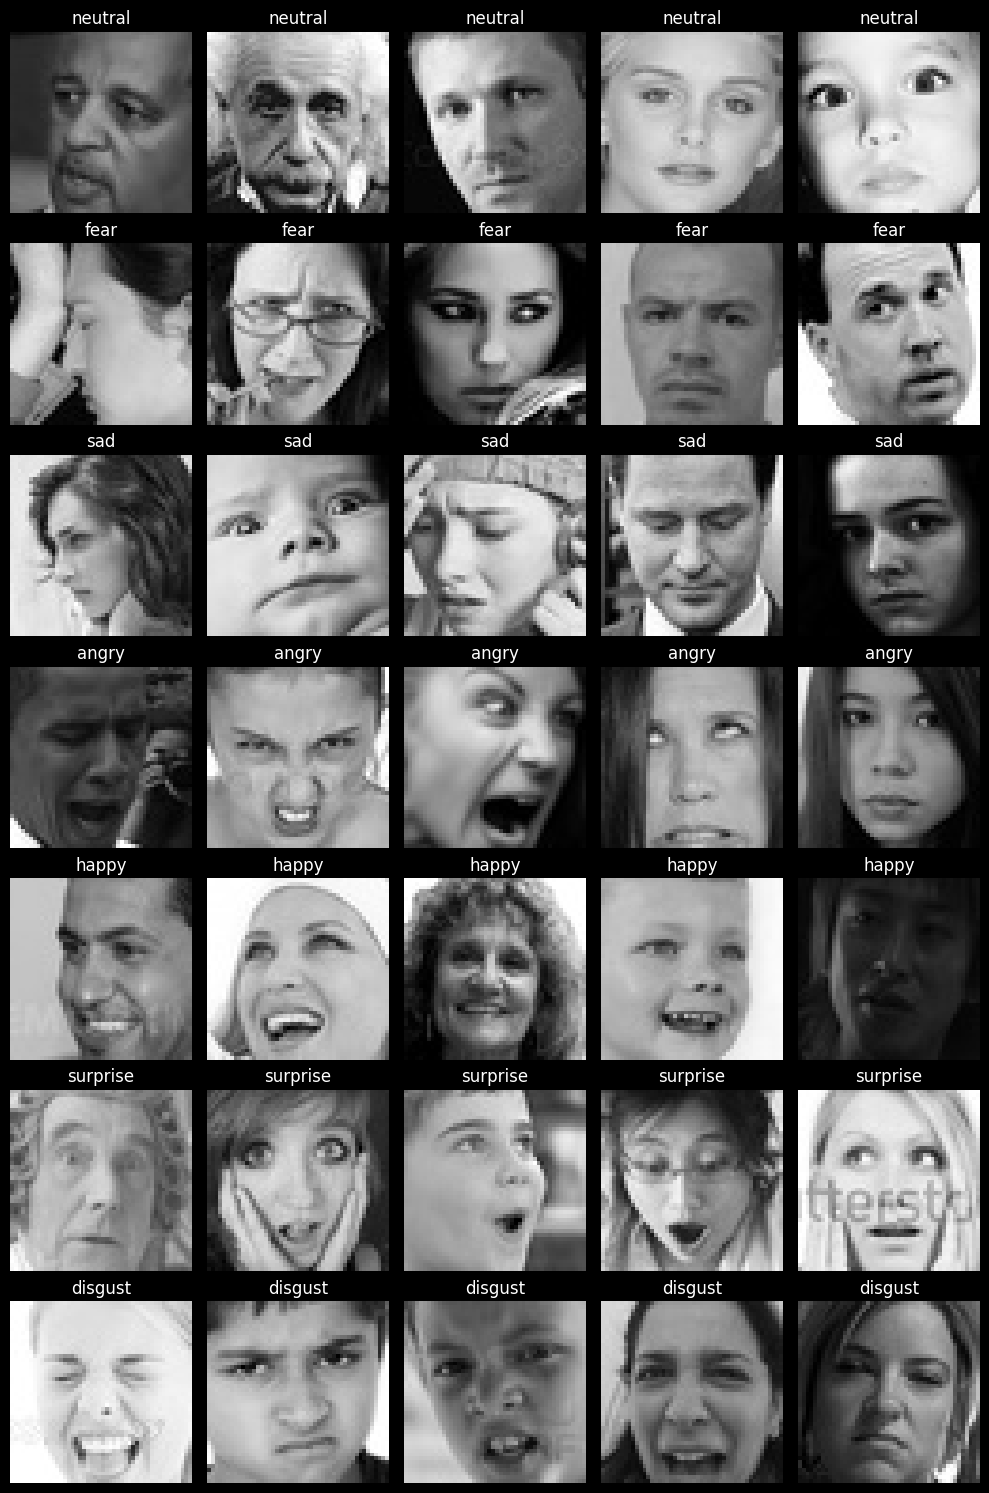

In [ ]:
# Viewing some of the images from each subdirectory in the train set with corresponding labels
cpt = 0
images = []
labels = []

plt.style.use('dark_background')
plt.figure(figsize=(10, 15))

# Iterate over each expression folder
for expression in os.listdir(folder_path + "train/"):
    for i in range(1, 6):
        cpt += 1
        plt.subplot(7, 5, cpt)

        img_path = folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i]
        img = load_img(img_path, target_size=(picture_size, picture_size))
        images.append(img)
        labels.append(expression)

        plt.imshow(img)
        plt.title(expression)
        plt.axis('off')

plt.tight_layout()
plt.show()


The images are not very sharp, and some are very dark while others are very bright. There are a range of different ages, as well as both male and female faces. Some of the images have obstacles covering part of the face, such as hands, text, or other objects. All of this makes it challenging to find a model that achieves satisfying prediction accuracy. It can be hard even for humans to decode facial expressions. Looking at the images above, not all seem to be the best representatives for the labels they have been assigned. This raises the question of how high an accuracy we should demand for a facial expression classifier in general, and particularly one trained on this dataset.

In [ ]:
# Counting the images in the the train and validation folders
total_train_images = 0
total_val_images = 0

# Iterate through each class in the train and validation directories
for i, j in zip(os.listdir(folder_path + "train"), os.listdir(folder_path + "validation")):
    train_count = len(os.listdir(folder_path + "train/" + i))
    val_count = len(os.listdir(folder_path + "validation/" + j))
    print(i + "\n" + "    train: " + str(train_count) + "\n" + "    validation: " + str(val_count))
    total_train_images += train_count
    total_val_images += val_count

print("\nTotal images in train set: " + str(total_train_images))
print("Total images in validation set: " + str(total_val_images))

disgust
    train: 436
    validation: 111
surprise
    train: 3205
    validation: 797
fear
    train: 4103
    validation: 1018
angry
    train: 3993
    validation: 960
happy
    train: 7164
    validation: 1825
sad
    train: 4938
    validation: 1139
neutral
    train: 4982
    validation: 1216

Total images in train set: 28821
Total images in validation set: 7066


In [ ]:
# A function that counts the images in the folders and the total amount to be used in a plots
def count_images_in_subdirectories(path):
    counts = {}
    total_count = 0
    for subdir in os.listdir(path):
        subdir_path = os.path.join(path, subdir)
        if os.path.isdir(subdir_path):
            image_count = len([f for f in os.listdir(subdir_path) if f.endswith('.jpg')])
            counts[subdir] = image_count
            total_count += image_count
    return counts, total_count


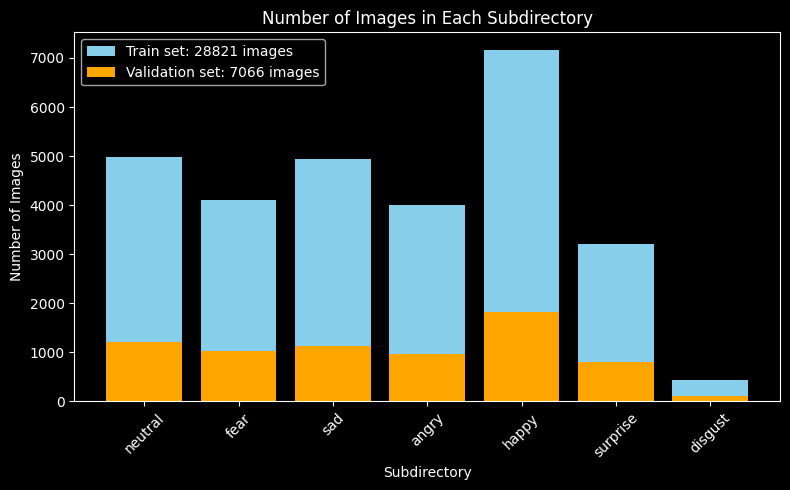

In [ ]:
# Plotting the distribution of labels in the train and validation set

# Retrieving images counts
train_path = "../content/images/train"
train_image_count, train_total_images = count_images_in_subdirectories(train_path)
val_path = "../content/images/validation"
val_image_count, val_total_images = count_images_in_subdirectories(val_path)

# Create list with classes and counts
train_subdirs = list(train_image_count.keys())
train_counts = list(train_image_count.values())
val_subdirs = list(val_image_count.keys())
val_counts = list(val_image_count.values())

plt.style.use('dark_background')

plt.figure(figsize=(8, 5))
plt.bar(train_subdirs, train_counts, color='skyblue', label="Train set: " + str(train_total_images) + " images")
plt.bar(val_subdirs, val_counts, color='orange', label="Validation set: " + str(val_total_images) + " images")
plt.xlabel('Subdirectory')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Subdirectory')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

The distribution of classes in the training and validation sets is similar, with a majority of happy faces and the fewest faces showing disgust. Labeling faces that express disgust can be a difficult task based on this dataset. There is a considerable difference in the number of happy images in the training set (7164) compared to images labeled as disgust (436).

One way to address this imbalance in the dataset is to use image augmentation to increase the variance in the dataset, thereby simulating a larger dataset. Another approach is to use oversampling to even out the distribution, a procedure that is tested later in this study.

# DATA PREPROCESSING <br>
In this section the dataset will be processed in different ways and we will create modified datasets that can be experimented with in the model training fase. The first step is to divide the images in the train set into a train and a validation set (20% used for validation) and labelling the images in the validation folder as our test set.

In [11]:
# dividing train into train and validation set (20%) and making the validation folder the test set with image_dataset_from_directory

batch_size = 128
img_height = 48
img_width = 48
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

folder_path = "../content/images/"

train_set = image_dataset_from_directory(
  folder_path+"train",
  labels='inferred',
  label_mode='categorical',
  class_names=class_names,
  color_mode = "grayscale",
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_set = image_dataset_from_directory(
  folder_path+"train",
  labels='inferred',
  label_mode='categorical',
  class_names=class_names,
  color_mode = "grayscale",
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_set = image_dataset_from_directory(
  folder_path+"validation",
  labels='inferred',
  label_mode='categorical',
  class_names=class_names,
  color_mode = "grayscale",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
Found 7066 files belonging to 7 classes.


In [ ]:
class_names = train_set.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
for i, class_name in enumerate(class_names):
    print(f"Class {i}: {class_name}")

Class 0: angry
Class 1: disgust
Class 2: fear
Class 3: happy
Class 4: neutral
Class 5: sad
Class 6: surprise


In [10]:
# Function to count occurrences of each class in a dataset
def count_class_occurrences(dataset):
    class_counts = np.zeros(len(class_names))
    for _, labels in dataset:
        class_counts += np.sum(labels, axis=0)
    return class_counts.astype(int)

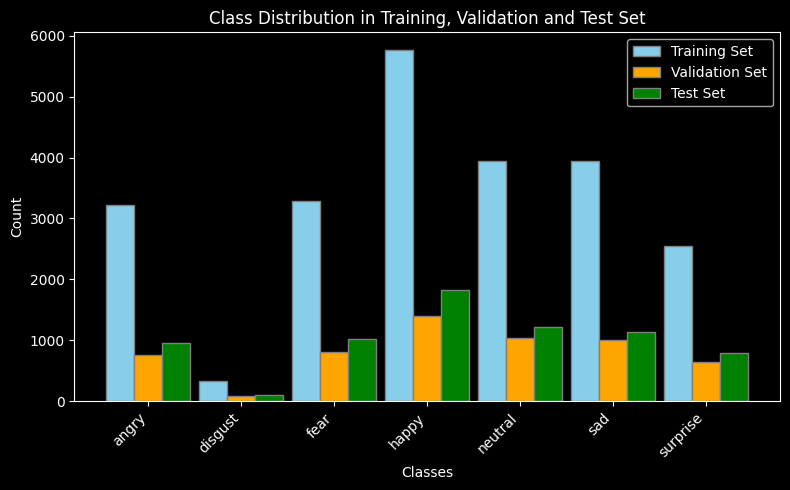

In [ ]:
# Shows distibution of the new training, validation and test set
train_class_counts = count_class_occurrences(train_set)
val_class_counts = count_class_occurrences(val_set)
test_class_counts = count_class_occurrences(test_set)

bar_width = 0.3

# Define the x locations for the groups
r1 = np.arange(len(class_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.style.use('dark_background')
plt.figure(figsize=(8, 5))
plt.bar(r1, train_class_counts, color='skyblue', width=bar_width, edgecolor='grey', label='Training Set')
plt.bar(r2, val_class_counts, color='orange', width=bar_width, edgecolor='grey', label='Validation Set')
plt.bar(r3, test_class_counts, color='green', width=bar_width, edgecolor='grey', label='Test Set')

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in Training, Validation and Test Set')
plt.xticks([r + bar_width for r in range(len(class_names))], class_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
for data in train_set.take(1):
    images, labels = data
    print("Images shape:", images.shape)
    print("Images dtype:", images.dtype)
    first_image = images[0].numpy()
    print("Flatten array of the first part of the first image:", first_image.flatten()[:20])
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    print("First label:", labels[0].numpy())

Images shape: (128, 48, 48, 1)
Images dtype: <dtype: 'float32'>
Flatten array of the first part of the first image: [ 23.  38.  52.  55.  63.  75.  83.  95. 102. 111. 112. 120. 125. 131.
 134. 138. 122. 115. 123. 130.]
Labels shape: (128, 7)
Labels dtype: <dtype: 'float32'>
First label: [0. 0. 0. 0. 0. 1. 0.]


Above we see the specifications for the train set. Every batch has 128 images of size 48x48 and they are greyscale. There are 128 images in the labels data and 7 classes. The image and label data are type float32.
The pixel values are from 0 to 250 and the labels are one hot encoded. Below the same information for the test set is printed as well.

In [ ]:
for data in test_set.take(1):
    images, labels = data
    print("Images shape:", images.shape)
    print("Images dtype:", images.dtype)
    first_image = images[0].numpy()
    print("Flatten array of the first part of the first image:", first_image.flatten()[:20])
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    print("First label:", labels[0].numpy())

Images shape: (128, 48, 48, 1)
Images dtype: <dtype: 'float32'>
Flatten array of the first part of the first image: [ 49.  50.  48.  51.  57.  56.  51.  50.  47.  47.  45.  45.  46.  60.
  84. 104. 117. 125. 126. 125.]
Labels shape: (128, 7)
Labels dtype: <dtype: 'float32'>
First label: [0. 0. 0. 0. 0. 1. 0.]


<br>**OVERSAMPLING OF THE DATASET**

A way to solve the issue with an imbalanced dataset is by using oversampling to even out the distribution of the classes. The sampled dataset will be prepared below with the SMOTE method and then used later in the model training section. There are some steps to take when applying the SMOTE method to our dataset. It needs to be converted to numpy arrays and reshaped, then smote can be applied. Afterwards the dataset needs to be reshaped again, labels one hot encoded and turned back into a tensorflow dataset.

In [11]:
# Function to convert TensorFlow dataset to image and label NumPy arrays
def tf_dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in train_set:
        images.append(img.numpy())
        labels.append(label.numpy())
    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)

train_images, train_labels = tf_dataset_to_numpy(train_set)

In [12]:
# Reshape one hot encoded data to single integer labels and reshape image shape before applying smote
train_labels_single = np.argmax(train_labels, axis=1)

n_samples, height, width, channels = train_images.shape
train_images_flat = train_images.reshape((n_samples, height * width * channels))

In [13]:
# Apply SMOTE and reshape back to original image shape and one hot encoding of the labels
smote = SMOTE()
train_images_resampled_flat, train_labels_resampled_single = smote.fit_resample(train_images_flat, train_labels_single)

train_images_resampled = train_images_resampled_flat.reshape((-1, height, width, channels))
train_labels_resampled = tf.keras.utils.to_categorical(train_labels_resampled_single, num_classes=7)

In [14]:
# Convert back to TensorFlow dataset and shuffle the dataset
train_set_smote = tf.data.Dataset.from_tensor_slices((train_images_resampled, train_labels_resampled))

batch_size = 128
train_smote = train_set_smote.shuffle(buffer_size=len(train_images_resampled)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_smote

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

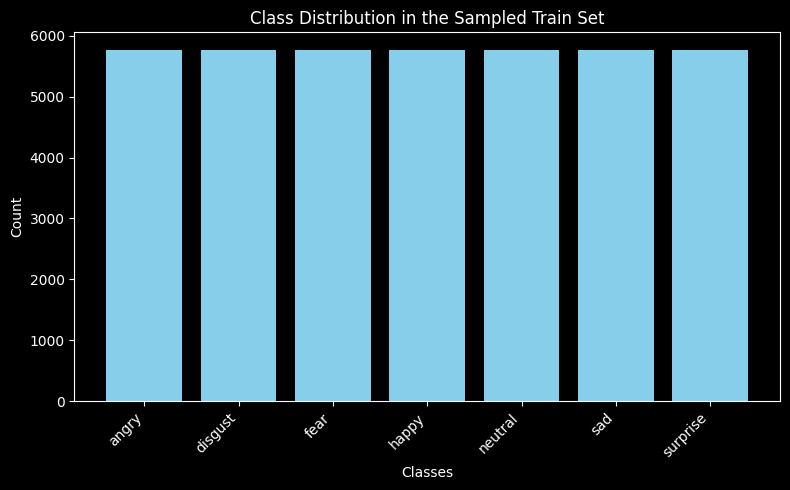

In [15]:
# Validating the oversampled datatset label distribution
train_smote_class_counts = count_class_occurrences(train_smote)

plt.style.use('dark_background')
plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(class_names)), train_smote_class_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in the Sampled Train Set')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Inspecting specifications for the oversampled train set
for data in train_smote.take(1):
    images, labels = data
    print("Images shape:", images.shape)
    print("Images dtype:", images.dtype)
    first_image = images[0].numpy()
    print("Flatten array of the first part of the first image:", first_image.flatten()[:20])
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    print("First label:", labels[0].numpy())

Images shape: (128, 48, 48, 1)
Images dtype: <dtype: 'float32'>
Flatten array of the first part of the first image: [204.36 196.84 191.46 192.71 187.45 179.42 179.42 178.68 186.18 187.94
 179.68 176.06 160.59 112.27  77.77  63.69  78.43  64.7   45.19  41.71]
Labels shape: (128, 7)
Labels dtype: <dtype: 'float32'>
First label: [0. 0. 0. 0. 1. 0. 0.]


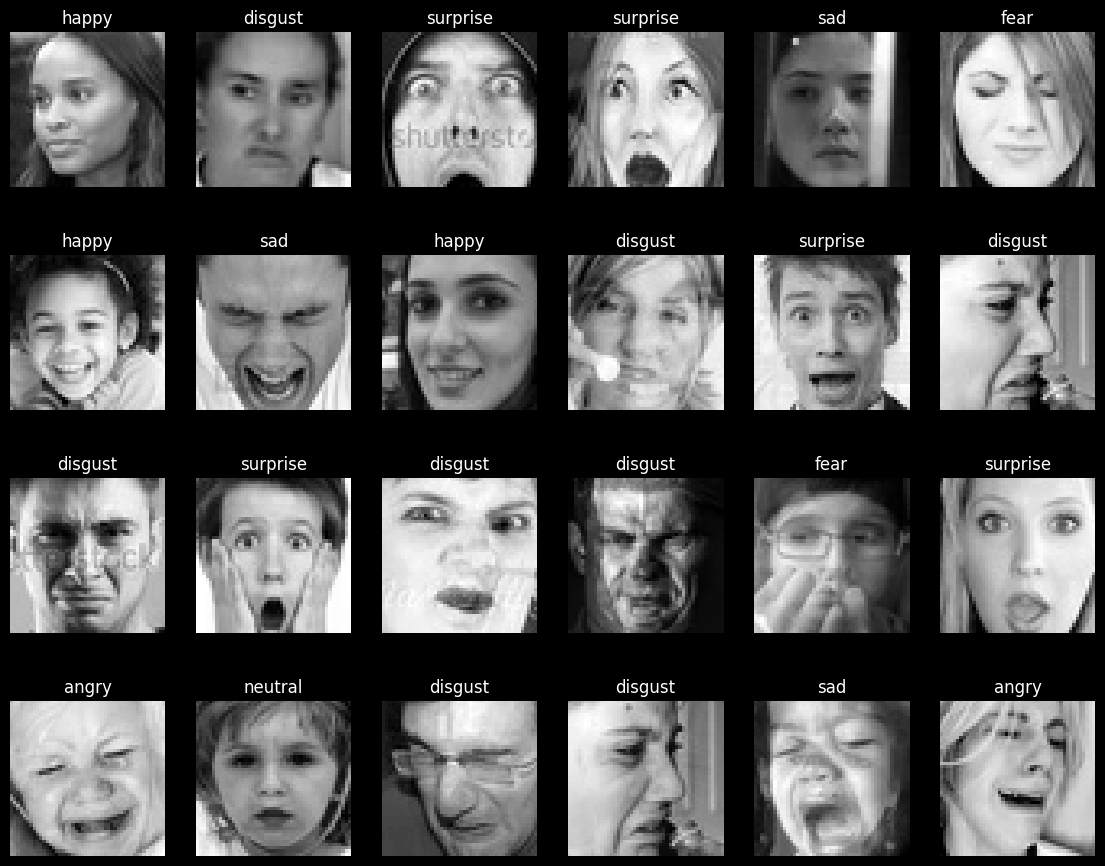

In [ ]:
# Inspecting some of the images in the sampled dataset
num_images_to_display = 24

for images, labels in train_smote.take(1):
    images = images[:num_images_to_display]
    labels = labels[:num_images_to_display]
    break

plt.figure(figsize=(14, 14))
for i in range(num_images_to_display):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(tf.squeeze(images[i]).numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[tf.argmax(labels[i]).numpy()])
    plt.axis("off")
plt.show()


Viewing the images in the new dataset shows both original images and images that are most likely sampled from the dataset. Several of the images are somewhat blurred and of lower quality compared to the standard images. Whether these sampled images will improve the predictions is uncertain since the quality is quite low. They could introduce more noise into the model training, potentially achieving the opposite of the intended effect.

<br>**LIMITED DATASET**<br><br>

In [17]:
# creating the limited dataset to be used when doing hyperparameter tuning
# Since we only have a bit over 400 disgust images samples_per_class is set to 400

original_dataset_dir = '/content/images/train'
limited_dataset_dir = '/content/images/limited_train'

os.makedirs(limited_dataset_dir, exist_ok=True)

samples_per_class = 400

for class_dir in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_dir)

    if os.path.isdir(class_path):
        files = os.listdir(class_path)
        selected_files = random.sample(files, min(samples_per_class, len(files)))

        new_class_path = os.path.join(limited_dataset_dir, class_dir)
        os.makedirs(new_class_path, exist_ok=True)

        for file_name in selected_files:
            src_file = os.path.join(class_path, file_name)
            dst_file = os.path.join(new_class_path, file_name)
            shutil.copyfile(src_file, dst_file)

print('Dataset creation complete.')

Dataset creation complete.


In [39]:
# loading the new dataaset with image_dataset_from_directory and setting 15% as a validation set

batch_size = 50
img_height = 48
img_width = 48
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

folder_path = "../content/images/"

limited_train_set = image_dataset_from_directory(
  folder_path+"limited_train",
  labels='inferred',
  label_mode='categorical',
  class_names=class_names,
  color_mode = "grayscale",
  validation_split=0.15,
  subset="training",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

limited_val_set = image_dataset_from_directory(
  folder_path+"limited_train",
  labels='inferred',
  label_mode='categorical',
  class_names=class_names,
  color_mode = "grayscale",
  validation_split=0.15,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5036 files belonging to 7 classes.
Using 4281 files for training.
Found 5036 files belonging to 7 classes.
Using 755 files for validation.


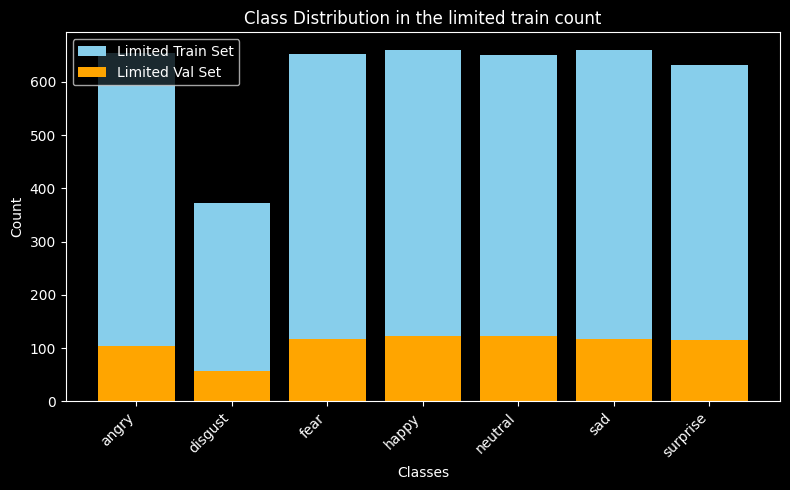

In [40]:
# Count occurrences of each class in training and validation sets
limited_train_count = count_class_occurrences(limited_train_set)
limited_val_count = count_class_occurrences(limited_val_set)

plt.style.use('dark_background')

plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(class_names)), limited_train_count, color='skyblue', label="Limited Train Set")
plt.bar(np.arange(len(class_names)), limited_val_count, color='orange', label="Limited Val Set")
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in the limited train count')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()


In the above section we viewed the images, the shape of the dataset and the distribution of the class labels as well as created different datasets to be used in the training process. To sum upp we have these datasets that will be used for model training: <br>
**train_set**: the baseline train set <br>
**train_smote**: the oversampled train set<br>
**limited_train_set and validation set**: a dataaset with 400 images from each class <br>

# MODEL 1

The first model to be trained is based on the model from the video https://www.youtube.com/watch?v=Bb4Wvl57LI. It is a Sequential model consisting of 4 convolutional layers and 2 Dense layers. It has Relu as the activation function in the layers and softmax in the output layer.

In [ ]:
no_of_classes = 7

model_1 = Sequential()

#1st CNN layer
model_1.add(Conv2D(64,(3,3),padding = 'same',input_shape = (img_height,img_width,1)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size = (2,2)))
model_1.add(Dropout(0.25))

#2nd CNN layer
model_1.add(Conv2D(128,(5,5),padding = 'same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size = (2,2)))
model_1.add(Dropout (0.25))

#3rd CNN layer
model_1.add(Conv2D(512,(3,3),padding = 'same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size = (2,2)))
model_1.add(Dropout (0.25))

#4th CNN layer
model_1.add(Conv2D(512,(3,3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Flatten())

#Fully connected 1st layer
model_1.add(Dense(256))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.25))

# Fully connected layer 2nd layer
model_1.add(Dense(512))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.25))

model_1.add(Dense(no_of_classes, activation='softmax'))

# model_1.summary()


In [ ]:
# Setting checkpoints and saving the best model
filepath_m1 = '/content/drive/MyDrive/Colab Notebooks/model_1.keras'

checkpoint = ModelCheckpoint(filepath_m1,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Use Early stopping when the validation loss have not improved for three epochs
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

# learning rate reduced with 20% from currect value if the val_loss does not improve after 3 epochs
# min_delta the minimum change in val_loss to qualify as and improvement
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

# compiling the model with adam optimizer, categorical_crossentory for multiclassification tasks and metric accuracy
model_1.compile(optimizer = Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# steps per epoch is left out, since all samples should be used in each epoch
history_1 = model_1.fit(train_set,
                    epochs=epochs,
                    validation_data=val_set,
                    callbacks=callbacks_list,
                    )

Epoch 1/48
177/181 [============================>.] - ETA: 0s - loss: 1.8148 - accuracy: 0.3051

181/181 [==============================] - 7s 16ms/step - loss: 1.8120 - accuracy: 0.3057 - val_loss: 1.7419 - val_accuracy: 0.3690 - lr: 0.0010
Epoch 2/48
181/181 [==============================] - ETA: 0s - loss: 1.4953 - accuracy: 0.4285

181/181 [==============================] - 3s 14ms/step - loss: 1.4953 - accuracy: 0.4285 - val_loss: 1.6918 - val_accuracy: 0.4283 - lr: 0.0010
Epoch 3/48
177/181 [============================>.] - ETA: 0s - loss: 1.3274 - accuracy: 0.4885

181/181 [==============================] - 3s 14ms/step - loss: 1.3251 - accuracy: 0.4894 - val_loss: 1.5065 - val_accuracy: 0.4445 - lr: 0.0010
Epoch 4/48
177/181 [============================>.] - ETA: 0s - loss: 1.2383 - accuracy: 0.5277

181/181 [==============================] - 3s 14ms/step - loss: 1.2378 - accuracy: 0.5276 - val_loss: 1.4313 - val_accuracy: 0.4299 - lr: 0.0010
Epoch 5/48
180/181 [============================>.] - ETA: 0s - loss: 1.1664 - accuracy: 0.5547

181/181 [==============================] - 3s 14ms/step - loss: 1.1665 - accuracy: 0.5546 - val_loss: 1.1958 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 6/48
180/181 [============================>.] - ETA: 0s - loss: 1.1164 - accuracy: 0.5776

181/181 [==============================] - 3s 14ms/step - loss: 1.1162 - accuracy: 0.5776 - val_loss: 1.3353 - val_accuracy: 0.4866 - lr: 0.0010
Epoch 7/48
177/181 [============================>.] - ETA: 0s - loss: 1.0671 - accuracy: 0.5940

181/181 [==============================] - 3s 14ms/step - loss: 1.0665 - accuracy: 0.5942 - val_loss: 1.1922 - val_accuracy: 0.5590 - lr: 0.0010
Epoch 8/48
177/181 [============================>.] - ETA: 0s - loss: 1.0233 - accuracy: 0.6082

181/181 [==============================] - 3s 14ms/step - loss: 1.0237 - accuracy: 0.6079 - val_loss: 1.1848 - val_accuracy: 0.5593 - lr: 0.0010
Epoch 9/48
177/181 [============================>.] - ETA: 0s - loss: 0.9765 - accuracy: 0.6294

181/181 [==============================] - 3s 14ms/step - loss: 0.9768 - accuracy: 0.6295 - val_loss: 1.1613 - val_accuracy: 0.5602 - lr: 0.0010
Epoch 10/48
179/181 [============================>.] - ETA: 0s - loss: 0.9418 - accuracy: 0.6452

181/181 [==============================] - 3s 14ms/step - loss: 0.9416 - accuracy: 0.6451 - val_loss: 1.1631 - val_accuracy: 0.5661 - lr: 0.0010
Epoch 11/48
177/181 [============================>.] - ETA: 0s - loss: 0.8915 - accuracy: 0.6653

181/181 [==============================] - 3s 14ms/step - loss: 0.8899 - accuracy: 0.6661 - val_loss: 1.2193 - val_accuracy: 0.5531 - lr: 0.0010
Epoch 12/48
178/181 [============================>.] - ETA: 0s - loss: 0.8494 - accuracy: 0.6785Restoring model weights from the end of the best epoch: 9.



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
181/181 [==============================] - 3s 14ms/step - loss: 0.8480 - accuracy: 0.6789 - val_loss: 1.2549 - val_accuracy: 0.5383 - lr: 0.0010
Epoch 12: early stopping


Running this model we get an accuracy of 53,83 % on the validation set and 67,89% on the training set. This is not so bad considering that we have 7 classes and the quality of the dataset.

In [ ]:
model_1.save(filepath_m1)

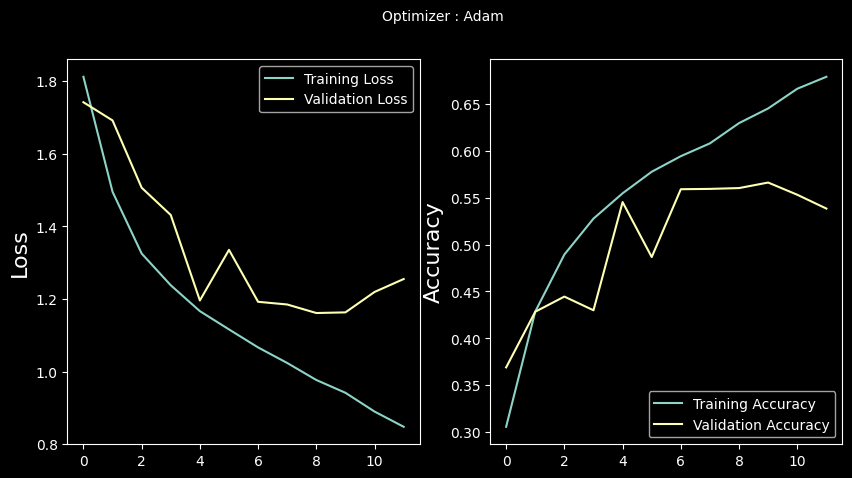

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

The validation curve is a bit jumpy, and in the last epochs, there is a significant difference between the curves. This could indicate that there is a problem with the model's ability to predict on new data and that it overfits the training data.
It might appear that the model performed better on the validation set than on the training set at the beginning of training, but that’s not the case. The validation error is computed at the end of each epoch, while the training error is computed during the epoch, so there is a mismatch in "time" between the two curves.

# MODEL 2
In the second model, an augmentation layer and a rescaling layer are added to the model. Data augmentation is a technique used to increase the diversity of a training dataset by applying random transformations to the images. This helps the model generalize better by learning from variations of the data.
Rescaling the pixel values before feeding them to the model is standard practice and usually increases the model's performance and stability.
The last change for model 2 is that patience is increased from 3 to 5 to give the model more time to train the data before stopping.

In [ ]:
# Initiating data augumentation. Flipped horizontally, RandomRotation of 15% of a circle and Zoom 15%
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal", input_shape=(img_height, img_width, 1)),
    RandomRotation(0.15),
    RandomZoom(0.15),
])

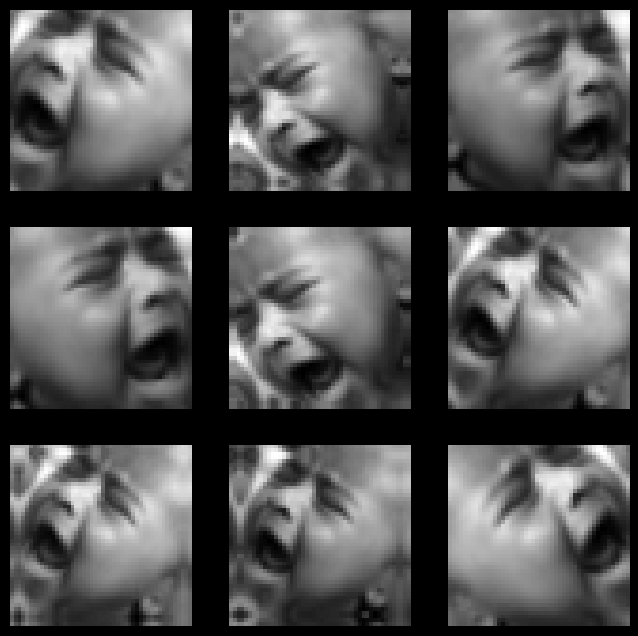

In [ ]:
# Inspecting an augmented image
plt.figure(figsize=(8, 8))
for images, _ in train_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        # Convert the image to 2D for correct grayscale display
        plt.imshow(tf.squeeze(augmented_images[0]).numpy(), cmap='gray')
        plt.axis("off")
plt.show()


In [ ]:
no_of_classes = 7

model_2 = Sequential()

# Rescaling the input
model_2.add(Rescaling(1./255, input_shape=(img_height, img_width, 1)))

# Add the data augmentation layer, which will be active during training
model_2.add(data_augmentation)

#1st CNN layer
model_2.add(Conv2D(64,(3,3),padding = 'same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size = (2,2)))
model_2.add(Dropout(0.25))

#2nd CNN layer
model_2.add(Conv2D(128,(5,5),padding = 'same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size = (2,2)))
model_2.add(Dropout (0.25))

#3rd CNN layer
model_2.add(Conv2D(512,(3,3),padding = 'same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size = (2,2)))
model_2.add(Dropout (0.25))

#4th CNN layer
model_2.add(Conv2D(512,(3,3), padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())

#Fully connected 1st layer
model_2.add(Dense(256))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(Dropout(0.25))

# Fully connected layer 2nd layer
model_2.add(Dense(512))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(Dropout(0.25))

model_2.add(Dense(no_of_classes, activation='softmax'))

#model_2.summary()

In [ ]:
# Setting checkpoints and saving the best model
filepath_m2 = '/content/drive/MyDrive/Colab Notebooks/model_2.keras'

checkpoint = ModelCheckpoint(filepath_m2,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max') # max for max val_acc

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model_2.compile(optimizer = Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Training the model on the augumented training set
history_2 = model_2.fit(train_set,
                    epochs=epochs,
                    validation_data = val_set,
                    callbacks=callbacks_list
                    )

Epoch 1/48
178/181 [============================>.] - ETA: 0s - loss: 1.9508 - accuracy: 0.2229

181/181 [==============================] - 7s 18ms/step - loss: 1.9503 - accuracy: 0.2229 - val_loss: 1.9424 - val_accuracy: 0.1952 - lr: 0.0010
Epoch 2/48
179/181 [============================>.] - ETA: 0s - loss: 1.8134 - accuracy: 0.2599

181/181 [==============================] - 3s 16ms/step - loss: 1.8130 - accuracy: 0.2599 - val_loss: 2.1956 - val_accuracy: 0.1806 - lr: 0.0010
Epoch 3/48
180/181 [============================>.] - ETA: 0s - loss: 1.7085 - accuracy: 0.3210

181/181 [==============================] - 3s 16ms/step - loss: 1.7085 - accuracy: 0.3209 - val_loss: 1.8494 - val_accuracy: 0.3324 - lr: 0.0010
Epoch 4/48
179/181 [============================>.] - ETA: 0s - loss: 1.5948 - accuracy: 0.3752

181/181 [==============================] - 3s 16ms/step - loss: 1.5946 - accuracy: 0.3751 - val_loss: 1.6974 - val_accuracy: 0.3633 - lr: 0.0010
Epoch 5/48
180/181 [============================>.] - ETA: 0s - loss: 1.5186 - accuracy: 0.4055

181/181 [==============================] - 3s 16ms/step - loss: 1.5191 - accuracy: 0.4053 - val_loss: 1.7722 - val_accuracy: 0.3671 - lr: 0.0010
Epoch 6/48
180/181 [============================>.] - ETA: 0s - loss: 1.4503 - accuracy: 0.4323

181/181 [==============================] - 3s 16ms/step - loss: 1.4504 - accuracy: 0.4323 - val_loss: 1.4477 - val_accuracy: 0.4405 - lr: 0.0010
Epoch 7/48
180/181 [============================>.] - ETA: 0s - loss: 1.4030 - accuracy: 0.4590

181/181 [==============================] - 3s 16ms/step - loss: 1.4031 - accuracy: 0.4590 - val_loss: 1.3491 - val_accuracy: 0.4870 - lr: 0.0010
Epoch 8/48
181/181 [==============================] - ETA: 0s - loss: 1.3623 - accuracy: 0.4752

181/181 [==============================] - 3s 16ms/step - loss: 1.3623 - accuracy: 0.4752 - val_loss: 1.5047 - val_accuracy: 0.4434 - lr: 0.0010
Epoch 9/48
179/181 [============================>.] - ETA: 0s - loss: 1.3330 - accuracy: 0.4866

181/181 [==============================] - 3s 16ms/step - loss: 1.3329 - accuracy: 0.4871 - val_loss: 1.2869 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 10/48
181/181 [==============================] - ETA: 0s - loss: 1.3079 - accuracy: 0.4938

181/181 [==============================] - 3s 16ms/step - loss: 1.3079 - accuracy: 0.4938 - val_loss: 1.2579 - val_accuracy: 0.5191 - lr: 0.0010
Epoch 11/48
180/181 [============================>.] - ETA: 0s - loss: 1.2882 - accuracy: 0.5053

181/181 [==============================] - 3s 16ms/step - loss: 1.2886 - accuracy: 0.5054 - val_loss: 1.3541 - val_accuracy: 0.4943 - lr: 0.0010
Epoch 12/48
180/181 [============================>.] - ETA: 0s - loss: 1.2688 - accuracy: 0.5117

181/181 [==============================] - 3s 16ms/step - loss: 1.2687 - accuracy: 0.5117 - val_loss: 1.2841 - val_accuracy: 0.5186 - lr: 0.0010
Epoch 13/48
177/181 [============================>.] - ETA: 0s - loss: 1.2544 - accuracy: 0.5181

181/181 [==============================] - 3s 16ms/step - loss: 1.2547 - accuracy: 0.5185 - val_loss: 1.2480 - val_accuracy: 0.5161 - lr: 0.0010
Epoch 14/48
181/181 [==============================] - ETA: 0s - loss: 1.2429 - accuracy: 0.5231

181/181 [==============================] - 3s 16ms/step - loss: 1.2429 - accuracy: 0.5231 - val_loss: 1.2870 - val_accuracy: 0.5127 - lr: 0.0010
Epoch 15/48
177/181 [============================>.] - ETA: 0s - loss: 1.2261 - accuracy: 0.5340

181/181 [==============================] - 3s 16ms/step - loss: 1.2259 - accuracy: 0.5339 - val_loss: 1.1714 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 16/48
180/181 [============================>.] - ETA: 0s - loss: 1.2178 - accuracy: 0.5320

181/181 [==============================] - 3s 16ms/step - loss: 1.2180 - accuracy: 0.5320 - val_loss: 1.2357 - val_accuracy: 0.5387 - lr: 0.0010
Epoch 17/48
177/181 [============================>.] - ETA: 0s - loss: 1.2011 - accuracy: 0.5424

181/181 [==============================] - 3s 16ms/step - loss: 1.2011 - accuracy: 0.5427 - val_loss: 1.2566 - val_accuracy: 0.5246 - lr: 0.0010
Epoch 18/48
180/181 [============================>.] - ETA: 0s - loss: 1.1899 - accuracy: 0.5462

181/181 [==============================] - 3s 16ms/step - loss: 1.1898 - accuracy: 0.5463 - val_loss: 1.2955 - val_accuracy: 0.5038 - lr: 0.0010
Epoch 19/48
180/181 [============================>.] - ETA: 0s - loss: 1.1872 - accuracy: 0.5457

181/181 [==============================] - 3s 16ms/step - loss: 1.1871 - accuracy: 0.5457 - val_loss: 1.2353 - val_accuracy: 0.5352 - lr: 0.0010
Epoch 20/48
180/181 [============================>.] - ETA: 0s - loss: 1.1825 - accuracy: 0.5464Restoring model weights from the end of the best epoch: 15.



Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
181/181 [==============================] - 3s 16ms/step - loss: 1.1825 - accuracy: 0.5463 - val_loss: 1.2870 - val_accuracy: 0.5016 - lr: 0.0010
Epoch 20: early stopping


Model 2 with the rescaling and augumentation layers gave a training accuracy on 54,63% and validation accuracy on 50,16% so a bit lower than model 1. But the difference in accuracy in the models are too small to conclude that the one is better than the other.

In [ ]:
model_2.save(filepath_m2)

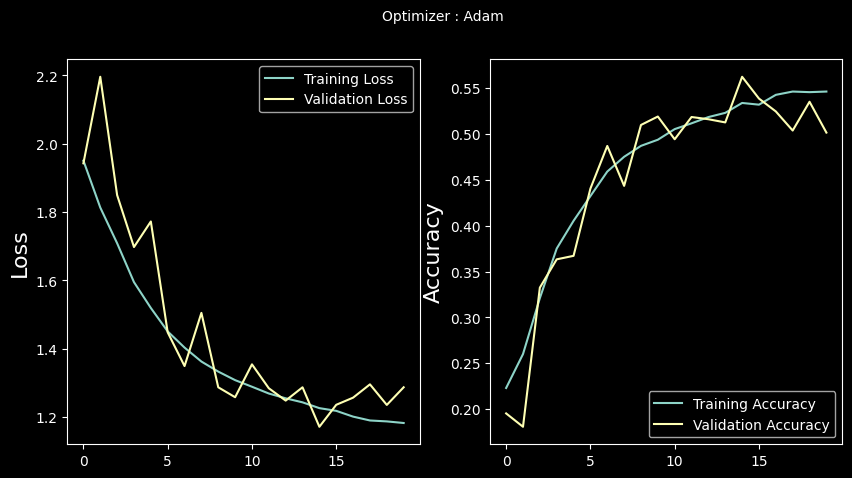

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

The validation curve is still quite jumpy, which is to be expected if the validation set is small. However, in general, the validation curve follows the training curve, indicating that the model does not overfit the training data. Even though the validation accuracy is lower than what we found for model_1, model_2 is less inclined to overfit the training data based on these training instances. It seems that adding the extra layers stabilized the model's performance.


# MODEL 3 <br>
Model 3 will be the same as model_1. The difference is that it will be trained on the oversampled dataset that were created under the Data Preprocessing section.

In [ ]:
no_of_classes = 7

model_3 = Sequential()

#1st CNN layer
model_3.add(Conv2D(64,(3,3),padding = 'same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Dropout(0.25))

#2nd CNN layer
model_3.add(Conv2D(128,(5,5),padding = 'same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Dropout (0.25))

#3rd CNN layer
model_3.add(Conv2D(512,(3,3),padding = 'same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size = (2,2)))
model_3.add(Dropout (0.25))

#4th CNN layer
model_3.add(Conv2D(512,(3,3), padding='same'))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())

#Fully connected 1st layer
model_3.add(Dense(256))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(Dropout(0.25))

# Fully connected layer 2nd layer
model_3.add(Dense(512))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(Dropout(0.25))

model_3.add(Dense(no_of_classes, activation='softmax'))

#model_3.summary()

In [ ]:
# Setting checkpoints and saving the best model
filepath_m3 = '/content/drive/MyDrive/Colab Notebooks/model_3.keras'

checkpoint = ModelCheckpoint(filepath_m3,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max') # max for max val_acc

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model_3.compile(optimizer = Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Training the model on the augumented training set - ad steps per epch again as in original code
history_3 = model_3.fit(train_smote,
                    epochs=epochs,
                    validation_data = val_set,
                    callbacks=callbacks_list
                    )

Epoch 1/48
316/316 [==============================] - ETA: 0s - loss: 1.7097 - accuracy: 0.3493

316/316 [==============================] - 9s 16ms/step - loss: 1.7097 - accuracy: 0.3493 - val_loss: 1.9977 - val_accuracy: 0.3097 - lr: 0.0010
Epoch 2/48
313/316 [============================>.] - ETA: 0s - loss: 1.2387 - accuracy: 0.5281

316/316 [==============================] - 4s 13ms/step - loss: 1.2383 - accuracy: 0.5282 - val_loss: 1.4022 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 3/48
312/316 [============================>.] - ETA: 0s - loss: 1.0542 - accuracy: 0.5994

316/316 [==============================] - 4s 13ms/step - loss: 1.0539 - accuracy: 0.5993 - val_loss: 1.3257 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 4/48
313/316 [============================>.] - ETA: 0s - loss: 0.9461 - accuracy: 0.6410

316/316 [==============================] - 4s 13ms/step - loss: 0.9472 - accuracy: 0.6408 - val_loss: 1.3973 - val_accuracy: 0.4651 - lr: 0.0010
Epoch 5/48
312/316 [============================>.] - ETA: 0s - loss: 0.8653 - accuracy: 0.6735

316/316 [==============================] - 4s 13ms/step - loss: 0.8654 - accuracy: 0.6733 - val_loss: 1.2670 - val_accuracy: 0.5323 - lr: 0.0010
Epoch 6/48
315/316 [============================>.] - ETA: 0s - loss: 0.7901 - accuracy: 0.7060

316/316 [==============================] - 4s 13ms/step - loss: 0.7902 - accuracy: 0.7060 - val_loss: 1.1744 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 7/48
313/316 [============================>.] - ETA: 0s - loss: 0.7277 - accuracy: 0.7285

316/316 [==============================] - 4s 13ms/step - loss: 0.7281 - accuracy: 0.7285 - val_loss: 1.2152 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 8/48
314/316 [============================>.] - ETA: 0s - loss: 0.6618 - accuracy: 0.7562

316/316 [==============================] - 4s 13ms/step - loss: 0.6621 - accuracy: 0.7560 - val_loss: 1.3479 - val_accuracy: 0.5448 - lr: 0.0010
Epoch 9/48
316/316 [==============================] - ETA: 0s - loss: 0.6021 - accuracy: 0.7795

316/316 [==============================] - 4s 13ms/step - loss: 0.6021 - accuracy: 0.7795 - val_loss: 1.2683 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 10/48
315/316 [============================>.] - ETA: 0s - loss: 0.5433 - accuracy: 0.8029

316/316 [==============================] - 4s 13ms/step - loss: 0.5433 - accuracy: 0.8028 - val_loss: 1.5197 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 11/48
312/316 [============================>.] - ETA: 0s - loss: 0.4839 - accuracy: 0.8245Restoring model weights from the end of the best epoch: 6.



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
316/316 [==============================] - 4s 13ms/step - loss: 0.4851 - accuracy: 0.8242 - val_loss: 1.3742 - val_accuracy: 0.5593 - lr: 0.0010
Epoch 11: early stopping


Model 3 gave a training accuracy of 82,42% and a validation accuracy on 0.55.93% which indicate that it overfits the training data. That it overfits the training data can also be viewed in the accuracy and loss curves below. So the sampled data did help improve accuracy but it were increased to much on the training data, suggesting that the model needs more regularization if it is to be trained on the oversampled dataset.

In [ ]:
model_3.save(filepath_m3)

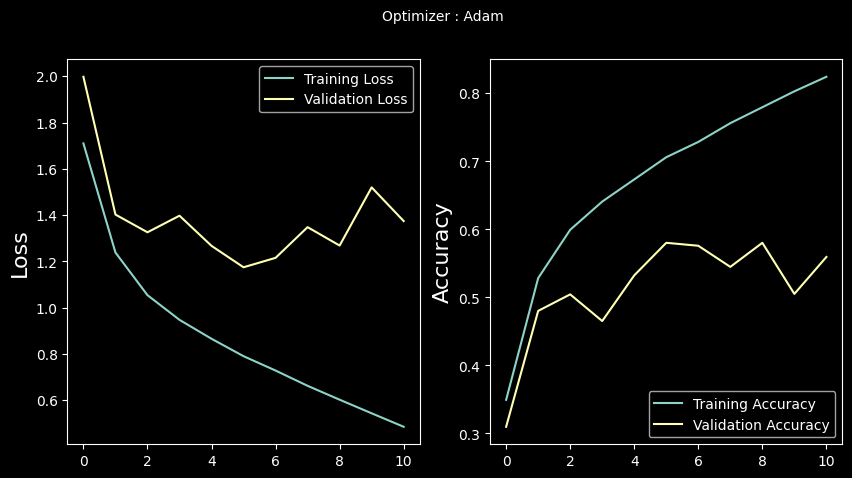

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# MODEL 4 <br>
The final model to be evaluated in this section is model_2, which includes rescaling and data augmentation layers, but this time it is trained on the oversampled training set. It was observed that these additional layers contributed to stabilizing the performance of the model and mitigating the risk of potential overfitting observed in model_1. It is possible that similar strategies could also address the overfitting issue observed in model_3.

In [ ]:
no_of_classes = 7

model_4 = Sequential()

# Rescaling the input
model_4.add(Rescaling(1./255, input_shape=(img_height, img_width, 1)))

# Add the data augmentation layer, which will be active during training
model_4.add(data_augmentation)

#1st CNN layer
model_4.add(Conv2D(64,(3,3),padding = 'same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size = (2,2)))
model_4.add(Dropout(0.25))

#2nd CNN layer
model_4.add(Conv2D(128,(5,5),padding = 'same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size = (2,2)))
model_4.add(Dropout (0.25))

#3rd CNN layer
model_4.add(Conv2D(512,(3,3),padding = 'same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size = (2,2)))
model_4.add(Dropout (0.25))

#4th CNN layer
model_4.add(Conv2D(512,(3,3), padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))

model_4.add(Flatten())

#Fully connected 1st layer
model_4.add(Dense(256))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(Dropout(0.25))

# Fully connected layer 2nd layer
model_4.add(Dense(512))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(Dropout(0.25))

model_4.add(Dense(no_of_classes, activation='softmax'))

#model_4.summary()

In [ ]:
# Setting checkpoints and saving the best model
filepath_m4 = '/content/drive/MyDrive/Colab Notebooks/model_4.keras'

checkpoint = ModelCheckpoint(filepath_m4,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max') # max for max val_acc

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model_4.compile(optimizer = Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Training the model on the augumented training set - ad steps per epch again as in original code
history_4 = model_4.fit(train_smote,
                    epochs=epochs,
                    validation_data = val_set,
                    callbacks=callbacks_list
                    )

Epoch 1/48
312/316 [============================>.] - ETA: 0s - loss: 1.9978 - accuracy: 0.2156

316/316 [==============================] - 9s 15ms/step - loss: 1.9964 - accuracy: 0.2162 - val_loss: 2.7160 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 2/48
315/316 [============================>.] - ETA: 0s - loss: 1.7511 - accuracy: 0.3161

316/316 [==============================] - 5s 15ms/step - loss: 1.7510 - accuracy: 0.3162 - val_loss: 2.0367 - val_accuracy: 0.2233 - lr: 0.0010
Epoch 3/48
316/316 [==============================] - ETA: 0s - loss: 1.5554 - accuracy: 0.4004

316/316 [==============================] - 5s 15ms/step - loss: 1.5554 - accuracy: 0.4004 - val_loss: 1.5006 - val_accuracy: 0.4101 - lr: 0.0010
Epoch 4/48
313/316 [============================>.] - ETA: 0s - loss: 1.4353 - accuracy: 0.4501

316/316 [==============================] - 5s 15ms/step - loss: 1.4346 - accuracy: 0.4503 - val_loss: 1.4532 - val_accuracy: 0.4558 - lr: 0.0010
Epoch 5/48
315/316 [============================>.] - ETA: 0s - loss: 1.3686 - accuracy: 0.4756

316/316 [==============================] - 5s 15ms/step - loss: 1.3686 - accuracy: 0.4756 - val_loss: 1.3973 - val_accuracy: 0.4736 - lr: 0.0010
Epoch 6/48
313/316 [============================>.] - ETA: 0s - loss: 1.3072 - accuracy: 0.5024

316/316 [==============================] - 5s 14ms/step - loss: 1.3075 - accuracy: 0.5020 - val_loss: 1.3623 - val_accuracy: 0.4797 - lr: 0.0010
Epoch 7/48
312/316 [============================>.] - ETA: 0s - loss: 1.2682 - accuracy: 0.5161

316/316 [==============================] - 5s 15ms/step - loss: 1.2688 - accuracy: 0.5159 - val_loss: 1.6459 - val_accuracy: 0.3810 - lr: 0.0010
Epoch 8/48
312/316 [============================>.] - ETA: 0s - loss: 1.2369 - accuracy: 0.5300

316/316 [==============================] - 5s 15ms/step - loss: 1.2362 - accuracy: 0.5302 - val_loss: 1.2028 - val_accuracy: 0.5387 - lr: 0.0010
Epoch 9/48
316/316 [==============================] - ETA: 0s - loss: 1.1989 - accuracy: 0.5438

316/316 [==============================] - 5s 15ms/step - loss: 1.1989 - accuracy: 0.5438 - val_loss: 1.2670 - val_accuracy: 0.5085 - lr: 0.0010
Epoch 10/48
316/316 [==============================] - ETA: 0s - loss: 1.1731 - accuracy: 0.5513

316/316 [==============================] - 5s 14ms/step - loss: 1.1731 - accuracy: 0.5513 - val_loss: 1.2715 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 11/48
313/316 [============================>.] - ETA: 0s - loss: 1.1545 - accuracy: 0.5602

316/316 [==============================] - 5s 15ms/step - loss: 1.1548 - accuracy: 0.5600 - val_loss: 1.2146 - val_accuracy: 0.5356 - lr: 0.0010
Epoch 12/48
313/316 [============================>.] - ETA: 0s - loss: 1.1332 - accuracy: 0.5676

316/316 [==============================] - 5s 14ms/step - loss: 1.1336 - accuracy: 0.5679 - val_loss: 1.2440 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 13/48
316/316 [==============================] - ETA: 0s - loss: 1.1160 - accuracy: 0.5750Restoring model weights from the end of the best epoch: 8.



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
316/316 [==============================] - 5s 15ms/step - loss: 1.1160 - accuracy: 0.5750 - val_loss: 1.3000 - val_accuracy: 0.5076 - lr: 0.0010
Epoch 13: early stopping


Model 4 gave an training accuracy on 57,50%  and a validation accuracy on 50,76%. As oppose to training model_1 on the oversampled dataset then we do not see the same signals of overfitting the training data when the rescaling and augumentation layer is added.

In [ ]:
model_4.save(filepath_m4)

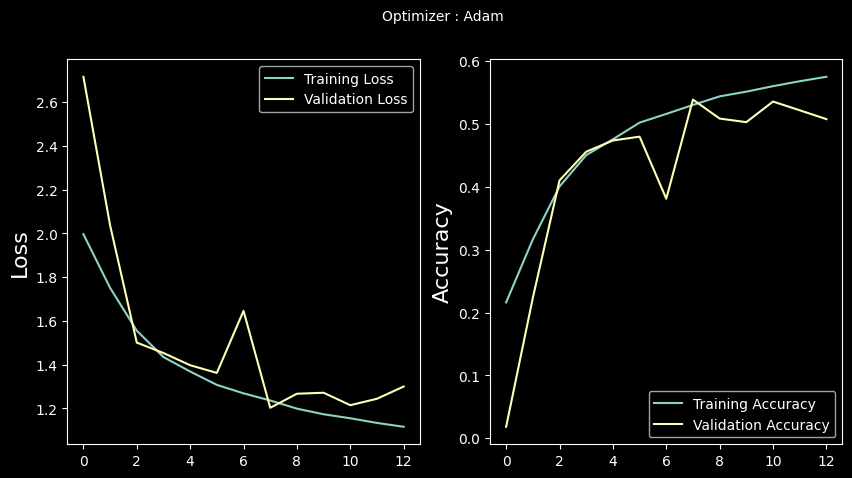

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_4.history['loss'], label='Training Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

The curves closely follow each other, and there isn't a significant deviation between the training and validation accuracy and losses. It appears that the model does not overfit the data, and the validation accuracy is acceptable. When examining the accuracy scores, they are quite similar to those of model 2, which was trained on the regular dataset. Based on this, we can conclude that the oversampled dataset did not negatively impact performance of model_2, but it also did not yield any significant improvement.

# TUNER SEARCH

In the previous section the focus were on training models with different sets of preprocessed data input. The following section will focus on tuning the hyperparameters of a model. The baseline model with a rescaling layer will surve as the basis of the model that will be build. The hyperparameters to be tested are as follows: <br><br>
- number of convolution layers <br>
- filters in the convolutional layers <br>
- kernel size<br>
- dropout rate after the convolutional layers<br>
- optimizers (adam vs rmsprop)<br>
- learning rate <br><br>

Tuning hyperparameters can take a long time. As a consequence the models will be tuned on the limited train set. The data augumentation layer is not added to the tuned model since it also would increase the tuning time. Tuning on a limited dataset will have a negative effect on the accuracy of the models since it has less material to learn from. The aim is to get the hyperparameters for the three best models and then train them on the whole train set to see if the accuracy did improve from the baseline model.<br>
The tuner will be conducted with the Hyperband tuner. This tuner randomly samples the different hyperparameter combinations and then train these for a few epochs. The best candidates are then selected for a full training with max epochs before the best models are found. This process can be repeated several times and are controlled by the hyperband_iteration argument.




In [26]:
# buidling the model to be tuned

no_of_classes = 7

def build_model(hp):
    model = Sequential()

    model.add(Rescaling(1./255, input_shape=(img_height, img_width, 1)))

    # Convolutional layers with different hyperparameters
    for i in range(hp.Int("conv_layers", 4, 6, default=4)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=64, max_value=512, step=64),
            kernel_size=hp.Int(f"kernel_size_{i}", 3, 5),
            padding="same"
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation("relu"))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(rate=hp.Choice(f"dropout_rate_{i}", [0.25, 0.50])))

    # Flatten layer
    model.add(layers.Flatten())

    # Adding dense layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # Output layer
    model.add(layers.Dense(no_of_classes, activation="softmax"))

    # Compile the model with two optimizers to be tested with different learning rates
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop"])
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")

    if optimizer_choice == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == "rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [ ]:
directory_path = '/content/drive/MyDrive/Colab Notebooks/tuner'

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory=directory_path,
    project_name='hp_tuner'
)

In [ ]:
tuner.search(limited_train_set,
             validation_data=limited_val_set,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 24 Complete [00h 06m 28s]
val_accuracy: 0.16190476715564728

Best val_accuracy So Far: 0.1785714328289032
Total elapsed time: 01h 13m 16s


In [ ]:
# Saving the 3 best models and their hyperparameters
save_dir = '/content/drive/MyDrive/Colab Notebooks/'

best_hyperparameters = tuner.get_best_hyperparameters(3)
best_models = [tuner.hypermodel.build(hp) for hp in best_hyperparameters]

# Save the best models and hyperparameters
for i, (hyperparameters, model) in enumerate(zip(best_hyperparameters, best_models), 1):
    model.save(os.path.join(save_dir, f'best_model_{i}.keras'))
    with open(os.path.join(save_dir, f'best_hp_{i}.json'), 'w') as f:
        json.dump(hyperparameters.get_config(), f)


# BEST MODEL 1

This section will train the best model found in the tuner search on the whole training set. The data augumentation layer will be added to increase the dataset. It was not added to the model that were tuned as it would have increased the training time.

In [ ]:
best_model_1 = load_model("drive/MyDrive/Colab Notebooks/best_model_1.keras")

In [ ]:
best_model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 48, 48, 1)         0         
                                                                 
 conv2d_46 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 batch_normalization_66 (Ba  (None, 48, 48, 128)       512       
 tchNormalization)                                               
                                                                 
 activation_66 (Activation)  (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_66 (Dropout)        (None, 24, 24, 128)     

In [ ]:
# Get the optimal hyperparameters for the best model
best_hps_1=tuner.get_best_hyperparameters(num_trials=1)[0]

best_filters = [best_hps_1.get(f'filters_{i}') for i in range(best_hps_1.get('conv_layers'))]
best_kernel_sizes = [best_hps_1.get(f'kernel_size_{i}') for i in range(best_hps_1.get('conv_layers'))]
best_dropout_rates = [best_hps_1.get(f'dropout_rate_{i}') for i in range(best_hps_1.get('conv_layers'))]
best_optimizer = best_hps_1.get('optimizer')
best_conv_layers = best_hps_1.get('conv_layers')
best_lr = best_hps_1.get('learning_rate')


[128, 192, 256, 192]
[5, 4, 4, 4]
[0.5, 0.25, 0.5, 0.25]
0.0022890471382902454
adam
4


In [ ]:
# buidling the best model from the tuner search and adding the data augumentation layer to increase the amount of data

no_of_classes = 7

model_5 = Sequential()

model_5.add(Rescaling(1./255, input_shape=(img_height, img_width, 1)))
model_5.add(data_augmentation)

#1st CNN layer
model_5.add(Conv2D(128,(5,5),padding = 'same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size = (2,2)))
model_5.add(Dropout(0.5))

#2nd CNN layer
model_5.add(Conv2D(192,(4,4),padding = 'same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size = (2,2)))
model_5.add(Dropout (0.25))

#3rd CNN layer
model_5.add(Conv2D(256,(4,4),padding = 'same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size = (2,2)))
model_5.add(Dropout (0.5))

#4th CNN layer
model_5.add(Conv2D(192,(4,4), padding='same'))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.25))

model_5.add(Flatten())

#Fully connected 1st layer
model_5.add(Dense(256))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(Dropout(0.25))

# Fully connected layer 2nd layer
model_5.add(Dense(512))
model_5.add(BatchNormalization())
model_5.add(Activation('relu'))
model_5.add(Dropout(0.25))

model_5.add(Dense(no_of_classes, activation='softmax'))


In [ ]:
filepath_m5 = '/content/drive/MyDrive/Colab Notebooks/model_5.keras'

checkpoint = ModelCheckpoint(filepath_m5,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

callbacks_list = [early_stopping,checkpoint]

epochs = 48

model_5.compile(optimizer = Adam(learning_rate=0.0023),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_5 = model_5.fit(train_set,
                    epochs=epochs,
                    validation_data = val_set,
                    callbacks=callbacks_list
                    )

Epoch 1/48
181/181 [==============================] - ETA: 0s - loss: 1.9234 - accuracy: 0.2270

181/181 [==============================] - 21s 63ms/step - loss: 1.9234 - accuracy: 0.2270 - val_loss: 1.8420 - val_accuracy: 0.2427
Epoch 2/48
180/181 [============================>.] - ETA: 0s - loss: 1.8194 - accuracy: 0.2494

181/181 [==============================] - 10s 56ms/step - loss: 1.8194 - accuracy: 0.2495 - val_loss: 1.8815 - val_accuracy: 0.2434
Epoch 3/48
180/181 [============================>.] - ETA: 0s - loss: 1.7504 - accuracy: 0.2902

181/181 [==============================] - 10s 55ms/step - loss: 1.7503 - accuracy: 0.2904 - val_loss: 1.9423 - val_accuracy: 0.2590
Epoch 4/48
180/181 [============================>.] - ETA: 0s - loss: 1.6930 - accuracy: 0.3220

181/181 [==============================] - 10s 56ms/step - loss: 1.6928 - accuracy: 0.3220 - val_loss: 1.7133 - val_accuracy: 0.3180
Epoch 5/48
180/181 [============================>.] - ETA: 0s - loss: 1.6303 - accuracy: 0.3539

181/181 [==============================] - 10s 56ms/step - loss: 1.6303 - accuracy: 0.3539 - val_loss: 1.6209 - val_accuracy: 0.3520
Epoch 6/48
180/181 [============================>.] - ETA: 0s - loss: 1.5742 - accuracy: 0.3830

181/181 [==============================] - 10s 56ms/step - loss: 1.5742 - accuracy: 0.3831 - val_loss: 1.7064 - val_accuracy: 0.3581
Epoch 7/48
180/181 [============================>.] - ETA: 0s - loss: 1.5250 - accuracy: 0.4021

181/181 [==============================] - 10s 56ms/step - loss: 1.5252 - accuracy: 0.4022 - val_loss: 1.6018 - val_accuracy: 0.3909
Epoch 8/48
180/181 [============================>.] - ETA: 0s - loss: 1.4881 - accuracy: 0.4197

181/181 [==============================] - 10s 55ms/step - loss: 1.4879 - accuracy: 0.4198 - val_loss: 1.6987 - val_accuracy: 0.3707
Epoch 9/48
180/181 [============================>.] - ETA: 0s - loss: 1.4450 - accuracy: 0.4387

181/181 [==============================] - 10s 55ms/step - loss: 1.4450 - accuracy: 0.4388 - val_loss: 1.4867 - val_accuracy: 0.4323
Epoch 10/48
180/181 [============================>.] - ETA: 0s - loss: 1.4183 - accuracy: 0.4477

181/181 [==============================] - 10s 56ms/step - loss: 1.4184 - accuracy: 0.4477 - val_loss: 1.4166 - val_accuracy: 0.4469
Epoch 11/48
180/181 [============================>.] - ETA: 0s - loss: 1.3902 - accuracy: 0.4634

181/181 [==============================] - 10s 56ms/step - loss: 1.3906 - accuracy: 0.4633 - val_loss: 1.4193 - val_accuracy: 0.4521
Epoch 12/48
180/181 [============================>.] - ETA: 0s - loss: 1.3678 - accuracy: 0.4739

181/181 [==============================] - 10s 55ms/step - loss: 1.3677 - accuracy: 0.4739 - val_loss: 1.4655 - val_accuracy: 0.4211
Epoch 13/48
180/181 [============================>.] - ETA: 0s - loss: 1.3355 - accuracy: 0.4816

181/181 [==============================] - 10s 55ms/step - loss: 1.3357 - accuracy: 0.4816 - val_loss: 1.4729 - val_accuracy: 0.4096
Epoch 14/48
180/181 [============================>.] - ETA: 0s - loss: 1.3287 - accuracy: 0.4876

181/181 [==============================] - 10s 55ms/step - loss: 1.3288 - accuracy: 0.4876 - val_loss: 1.3890 - val_accuracy: 0.4768
Epoch 15/48
180/181 [============================>.] - ETA: 0s - loss: 1.3050 - accuracy: 0.4983

181/181 [==============================] - 10s 55ms/step - loss: 1.3050 - accuracy: 0.4984 - val_loss: 1.3186 - val_accuracy: 0.4971
Epoch 16/48
180/181 [============================>.] - ETA: 0s - loss: 1.2971 - accuracy: 0.4997

181/181 [==============================] - 10s 55ms/step - loss: 1.2972 - accuracy: 0.4996 - val_loss: 1.3409 - val_accuracy: 0.4774
Epoch 17/48
180/181 [============================>.] - ETA: 0s - loss: 1.2785 - accuracy: 0.5084

181/181 [==============================] - 10s 55ms/step - loss: 1.2785 - accuracy: 0.5084 - val_loss: 1.2989 - val_accuracy: 0.5000
Epoch 18/48
180/181 [============================>.] - ETA: 0s - loss: 1.2695 - accuracy: 0.5152

181/181 [==============================] - 10s 55ms/step - loss: 1.2695 - accuracy: 0.5152 - val_loss: 1.4118 - val_accuracy: 0.4717
Epoch 19/48
180/181 [============================>.] - ETA: 0s - loss: 1.2596 - accuracy: 0.5170

181/181 [==============================] - 10s 55ms/step - loss: 1.2593 - accuracy: 0.5172 - val_loss: 1.4033 - val_accuracy: 0.4537
Epoch 20/48
180/181 [============================>.] - ETA: 0s - loss: 1.2428 - accuracy: 0.5232

181/181 [==============================] - 10s 55ms/step - loss: 1.2429 - accuracy: 0.5231 - val_loss: 1.2207 - val_accuracy: 0.5330
Epoch 21/48
180/181 [============================>.] - ETA: 0s - loss: 1.2411 - accuracy: 0.5241

181/181 [==============================] - 10s 55ms/step - loss: 1.2412 - accuracy: 0.5241 - val_loss: 1.4888 - val_accuracy: 0.4037
Epoch 22/48
180/181 [============================>.] - ETA: 0s - loss: 1.2262 - accuracy: 0.5309

181/181 [==============================] - 10s 55ms/step - loss: 1.2261 - accuracy: 0.5310 - val_loss: 1.2981 - val_accuracy: 0.4983
Epoch 23/48
180/181 [============================>.] - ETA: 0s - loss: 1.2169 - accuracy: 0.5345

181/181 [==============================] - 10s 55ms/step - loss: 1.2168 - accuracy: 0.5346 - val_loss: 1.3615 - val_accuracy: 0.4823
Epoch 24/48
180/181 [============================>.] - ETA: 0s - loss: 1.2189 - accuracy: 0.5355

181/181 [==============================] - 10s 55ms/step - loss: 1.2191 - accuracy: 0.5355 - val_loss: 1.4625 - val_accuracy: 0.4342
Epoch 25/48
180/181 [============================>.] - ETA: 0s - loss: 1.2026 - accuracy: 0.5409Restoring model weights from the end of the best epoch: 20.


181/181 [==============================] - 10s 55ms/step - loss: 1.2028 - accuracy: 0.5409 - val_loss: 1.2407 - val_accuracy: 0.5352
Epoch 25: early stopping


The model gave a training accuracy on 54,9% an a validation accuracy on 53,52%. The scores do not show a big improvement from the earlier models, but not a worse one either.

In [ ]:
model_5.save(filepath_m5)

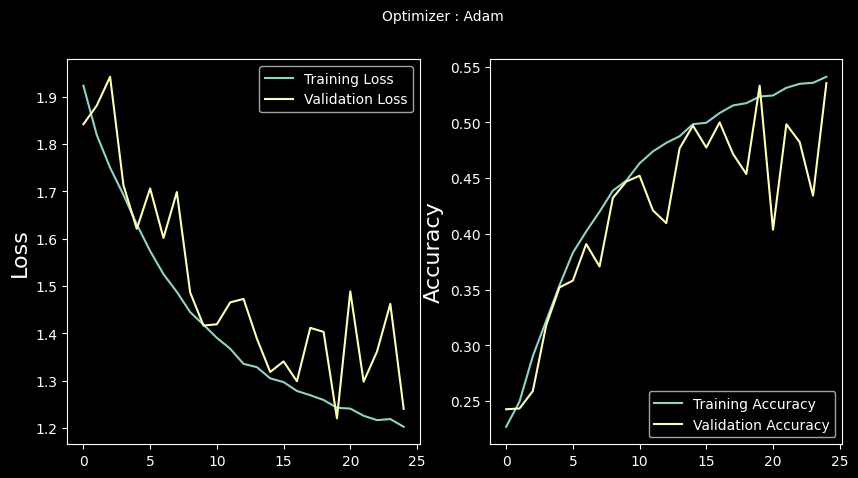

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_5.history['loss'], label='Training Loss')
plt.plot(history_5.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_5.history['accuracy'], label='Training Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

The curves follow each other and it does not seem that the model overfits the training data.

# BEST MODEL 2

In [ ]:
best_model_2 = load_model("drive/MyDrive/Colab Notebooks/best_model_2.keras")

In [ ]:
best_model_2.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 48, 48, 1)         0         
                                                                 
 conv2d_50 (Conv2D)          (None, 48, 48, 256)       4352      
                                                                 
 batch_normalization_72 (Ba  (None, 48, 48, 256)       1024      
 tchNormalization)                                               
                                                                 
 activation_72 (Activation)  (None, 48, 48, 256)       0         
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 24, 24, 256)       0         
 ng2D)                                                           
                                                                 
 dropout_72 (Dropout)        (None, 24, 24, 256)     

In [ ]:
# Get the optimal hyperparameters for the second best model
best_hps_2=tuner.get_best_hyperparameters(num_trials=2)[1]

best_filters_2 = [best_hps_2.get(f'filters_{i}') for i in range(best_hps_2.get('conv_layers'))]
best_kernel_sizes_2 = [best_hps_2.get(f'kernel_size_{i}') for i in range(best_hps_2.get('conv_layers'))]
best_dropout_rates_2 = [best_hps_2.get(f'dropout_rate_{i}') for i in range(best_hps_2.get('conv_layers'))]
best_optimizer_2 = best_hps_2.get('optimizer')
best_conv_layers_2 = best_hps_2.get('conv_layers')
best_lr_2 = best_hps_2.get('learning_rate')

print(f'best filters: {best_filters_2}')
print(f'best kernel sizes: {best_kernel_sizes_2}')
print(f'best dropout rate: {best_dropout_rates_2}')
print(f'best learning rate: {best_lr_2}')
print(f'best optimizer: {best_optimizer_2}')
print(f'best number of convolutional layers: {best_conv_layers_2}')


best filters: [256, 320, 128, 384, 192]
best kernel sizes: [4, 5, 3, 4, 4]
best dropout rate: [0.5, 0.25, 0.25, 0.25, 0.25]
best learning rate: 0.0035899035604446293
best optimizer: rmsprop
best numbe of convolutional layers: 5


In [ ]:
# buidling the second best model with the data augumentation layer
no_of_classes = 7

model_6 = Sequential()

# Rescaling and Augumenting the input
model_6.add(Rescaling(1./255, input_shape=(img_height, img_width, 1)))
model_6.add(data_augmentation)

#1st CNN layer
model_6.add(Conv2D(256,(4,4),padding = 'same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size = (2,2)))
model_6.add(Dropout(0.5))

#2nd CNN layer
model_6.add(Conv2D(320,(5,5),padding = 'same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size = (2,2)))
model_6.add(Dropout (0.25))

#3rd CNN layer
model_6.add(Conv2D(128,(3,3),padding = 'same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size = (2,2)))
model_6.add(Dropout (0.25))

#4th CNN layer
model_6.add(Conv2D(384,(4,4), padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))
model_6.add(Dropout(0.25))

#5th CNN layer
model_6.add(Conv2D(192,(4,4), padding='same'))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))
model_6.add(Dropout(0.25))

model_6.add(Flatten())

#Fully connected 1st layer
model_6.add(Dense(256))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(Dropout(0.25))

# Fully connected layer 2nd layer
model_6.add(Dense(512))
model_6.add(BatchNormalization())
model_6.add(Activation('relu'))
model_6.add(Dropout(0.25))

model_6.add(Dense(no_of_classes, activation='softmax'))

In [ ]:
filepath_m6 = '/content/drive/MyDrive/Colab Notebooks/model_6.keras'

checkpoint = ModelCheckpoint(filepath_m6,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

callbacks_list = [early_stopping,checkpoint]

epochs = 48

model_6.compile(optimizer = RMSprop(learning_rate=0.0036),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_6 = model_6.fit(train_set,
                    epochs=epochs,
                    validation_data = val_set,
                    callbacks=callbacks_list
                    )

Epoch 1/48
181/181 [==============================] - ETA: 0s - loss: 1.9737 - accuracy: 0.2192

181/181 [==============================] - 29s 116ms/step - loss: 1.9737 - accuracy: 0.2192 - val_loss: 1.8253 - val_accuracy: 0.2425
Epoch 2/48
180/181 [============================>.] - ETA: 0s - loss: 1.8604 - accuracy: 0.2462

181/181 [==============================] - 19s 106ms/step - loss: 1.8603 - accuracy: 0.2463 - val_loss: 1.9095 - val_accuracy: 0.1471
Epoch 3/48
180/181 [============================>.] - ETA: 0s - loss: 1.7699 - accuracy: 0.2967

181/181 [==============================] - 19s 106ms/step - loss: 1.7697 - accuracy: 0.2967 - val_loss: 2.6238 - val_accuracy: 0.2458
Epoch 4/48
180/181 [============================>.] - ETA: 0s - loss: 1.6780 - accuracy: 0.3409

181/181 [==============================] - 19s 106ms/step - loss: 1.6779 - accuracy: 0.3409 - val_loss: 1.8585 - val_accuracy: 0.2568
Epoch 5/48
180/181 [============================>.] - ETA: 0s - loss: 1.5952 - accuracy: 0.3723

181/181 [==============================] - 19s 106ms/step - loss: 1.5952 - accuracy: 0.3723 - val_loss: 1.7893 - val_accuracy: 0.3102
Epoch 6/48
180/181 [============================>.] - ETA: 0s - loss: 1.5260 - accuracy: 0.4020

181/181 [==============================] - 19s 106ms/step - loss: 1.5262 - accuracy: 0.4018 - val_loss: 2.2295 - val_accuracy: 0.1848
Epoch 7/48
180/181 [============================>.] - ETA: 0s - loss: 1.4689 - accuracy: 0.4285

181/181 [==============================] - 19s 107ms/step - loss: 1.4690 - accuracy: 0.4285 - val_loss: 1.6246 - val_accuracy: 0.3819
Epoch 8/48
180/181 [============================>.] - ETA: 0s - loss: 1.4256 - accuracy: 0.4486

181/181 [==============================] - 19s 107ms/step - loss: 1.4258 - accuracy: 0.4485 - val_loss: 2.3194 - val_accuracy: 0.1853
Epoch 9/48
180/181 [============================>.] - ETA: 0s - loss: 1.3979 - accuracy: 0.4614

181/181 [==============================] - 19s 107ms/step - loss: 1.3981 - accuracy: 0.4614 - val_loss: 1.7874 - val_accuracy: 0.2618
Epoch 10/48
180/181 [============================>.] - ETA: 0s - loss: 1.3640 - accuracy: 0.4727

181/181 [==============================] - 19s 107ms/step - loss: 1.3641 - accuracy: 0.4726 - val_loss: 1.5037 - val_accuracy: 0.4070
Epoch 11/48
180/181 [============================>.] - ETA: 0s - loss: 1.3416 - accuracy: 0.4893

181/181 [==============================] - 19s 107ms/step - loss: 1.3419 - accuracy: 0.4892 - val_loss: 1.4899 - val_accuracy: 0.4167
Epoch 12/48
180/181 [============================>.] - ETA: 0s - loss: 1.3245 - accuracy: 0.4929

181/181 [==============================] - 19s 107ms/step - loss: 1.3252 - accuracy: 0.4928 - val_loss: 1.7158 - val_accuracy: 0.3364
Epoch 13/48
180/181 [============================>.] - ETA: 0s - loss: 1.3023 - accuracy: 0.5017

181/181 [==============================] - 19s 106ms/step - loss: 1.3025 - accuracy: 0.5016 - val_loss: 1.6074 - val_accuracy: 0.3326
Epoch 14/48
180/181 [============================>.] - ETA: 0s - loss: 1.2823 - accuracy: 0.5098

181/181 [==============================] - 19s 106ms/step - loss: 1.2825 - accuracy: 0.5099 - val_loss: 1.4616 - val_accuracy: 0.4308
Epoch 15/48
180/181 [============================>.] - ETA: 0s - loss: 1.2697 - accuracy: 0.5208

181/181 [==============================] - 19s 106ms/step - loss: 1.2697 - accuracy: 0.5207 - val_loss: 1.5577 - val_accuracy: 0.3860
Epoch 16/48
180/181 [============================>.] - ETA: 0s - loss: 1.2516 - accuracy: 0.5248

181/181 [==============================] - 19s 106ms/step - loss: 1.2518 - accuracy: 0.5247 - val_loss: 1.3827 - val_accuracy: 0.4816
Epoch 17/48
180/181 [============================>.] - ETA: 0s - loss: 1.2489 - accuracy: 0.5253

181/181 [==============================] - 19s 107ms/step - loss: 1.2491 - accuracy: 0.5253 - val_loss: 1.6182 - val_accuracy: 0.3904
Epoch 18/48
180/181 [============================>.] - ETA: 0s - loss: 1.2380 - accuracy: 0.5289

181/181 [==============================] - 19s 106ms/step - loss: 1.2381 - accuracy: 0.5288 - val_loss: 1.6875 - val_accuracy: 0.2982
Epoch 19/48
180/181 [============================>.] - ETA: 0s - loss: 1.2199 - accuracy: 0.5347

181/181 [==============================] - 19s 106ms/step - loss: 1.2199 - accuracy: 0.5346 - val_loss: 1.6506 - val_accuracy: 0.3178
Epoch 20/48
180/181 [============================>.] - ETA: 0s - loss: 1.2159 - accuracy: 0.5372

181/181 [==============================] - 19s 107ms/step - loss: 1.2158 - accuracy: 0.5372 - val_loss: 1.7430 - val_accuracy: 0.2902
Epoch 21/48
180/181 [============================>.] - ETA: 0s - loss: 1.2135 - accuracy: 0.5370

181/181 [==============================] - 19s 106ms/step - loss: 1.2136 - accuracy: 0.5370 - val_loss: 1.3366 - val_accuracy: 0.4794
Epoch 22/48
180/181 [============================>.] - ETA: 0s - loss: 1.1900 - accuracy: 0.5472

181/181 [==============================] - 19s 106ms/step - loss: 1.1901 - accuracy: 0.5472 - val_loss: 1.4735 - val_accuracy: 0.4443
Epoch 23/48
180/181 [============================>.] - ETA: 0s - loss: 1.1920 - accuracy: 0.5507

181/181 [==============================] - 19s 106ms/step - loss: 1.1918 - accuracy: 0.5507 - val_loss: 1.3268 - val_accuracy: 0.4977
Epoch 24/48
180/181 [============================>.] - ETA: 0s - loss: 1.1776 - accuracy: 0.5543

181/181 [==============================] - 19s 107ms/step - loss: 1.1777 - accuracy: 0.5543 - val_loss: 1.2922 - val_accuracy: 0.5094
Epoch 25/48
180/181 [============================>.] - ETA: 0s - loss: 1.1737 - accuracy: 0.5556

181/181 [==============================] - 20s 108ms/step - loss: 1.1734 - accuracy: 0.5557 - val_loss: 1.3543 - val_accuracy: 0.4724
Epoch 26/48
180/181 [============================>.] - ETA: 0s - loss: 1.1658 - accuracy: 0.5561

181/181 [==============================] - 19s 107ms/step - loss: 1.1658 - accuracy: 0.5561 - val_loss: 1.4120 - val_accuracy: 0.4715
Epoch 27/48
180/181 [============================>.] - ETA: 0s - loss: 1.1612 - accuracy: 0.5590

181/181 [==============================] - 19s 107ms/step - loss: 1.1615 - accuracy: 0.5589 - val_loss: 1.2717 - val_accuracy: 0.5219
Epoch 28/48
180/181 [============================>.] - ETA: 0s - loss: 1.1524 - accuracy: 0.5629

181/181 [==============================] - 19s 107ms/step - loss: 1.1526 - accuracy: 0.5628 - val_loss: 1.7233 - val_accuracy: 0.3328
Epoch 29/48
180/181 [============================>.] - ETA: 0s - loss: 1.1470 - accuracy: 0.5687

181/181 [==============================] - 19s 107ms/step - loss: 1.1468 - accuracy: 0.5689 - val_loss: 1.6210 - val_accuracy: 0.3718
Epoch 30/48
180/181 [============================>.] - ETA: 0s - loss: 1.1362 - accuracy: 0.5679

181/181 [==============================] - 19s 107ms/step - loss: 1.1361 - accuracy: 0.5679 - val_loss: 1.5254 - val_accuracy: 0.3959
Epoch 31/48
180/181 [============================>.] - ETA: 0s - loss: 1.1358 - accuracy: 0.5701

181/181 [==============================] - 19s 106ms/step - loss: 1.1356 - accuracy: 0.5702 - val_loss: 1.2386 - val_accuracy: 0.5378
Epoch 32/48
180/181 [============================>.] - ETA: 0s - loss: 1.1248 - accuracy: 0.5740

181/181 [==============================] - 19s 106ms/step - loss: 1.1252 - accuracy: 0.5739 - val_loss: 1.2121 - val_accuracy: 0.5449
Epoch 33/48
180/181 [============================>.] - ETA: 0s - loss: 1.1215 - accuracy: 0.5746

181/181 [==============================] - 19s 106ms/step - loss: 1.1221 - accuracy: 0.5744 - val_loss: 1.5231 - val_accuracy: 0.4644
Epoch 34/48
180/181 [============================>.] - ETA: 0s - loss: 1.1231 - accuracy: 0.5748

181/181 [==============================] - 19s 107ms/step - loss: 1.1231 - accuracy: 0.5748 - val_loss: 1.2214 - val_accuracy: 0.5326
Epoch 35/48
180/181 [============================>.] - ETA: 0s - loss: 1.1109 - accuracy: 0.5799

181/181 [==============================] - 19s 106ms/step - loss: 1.1107 - accuracy: 0.5801 - val_loss: 1.4416 - val_accuracy: 0.4518
Epoch 36/48
180/181 [============================>.] - ETA: 0s - loss: 1.1053 - accuracy: 0.5836

181/181 [==============================] - 19s 106ms/step - loss: 1.1056 - accuracy: 0.5835 - val_loss: 1.7226 - val_accuracy: 0.3076
Epoch 37/48
180/181 [============================>.] - ETA: 0s - loss: 1.1038 - accuracy: 0.5869Restoring model weights from the end of the best epoch: 32.


181/181 [==============================] - 19s 106ms/step - loss: 1.1039 - accuracy: 0.5871 - val_loss: 1.6433 - val_accuracy: 0.3520
Epoch 37: early stopping


The second best model from the tuner search gave a lower validation accuracy and a greater deviance between the training and validation accuracy suggesting that it overfits the training data.

In [ ]:
model_6.save(filepath_m6)

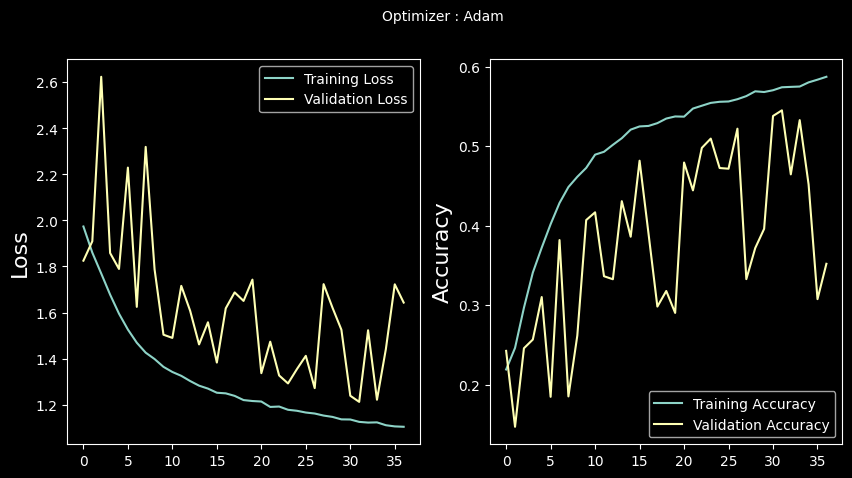

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_6.history['loss'], label='Training Loss')
plt.plot(history_6.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_6.history['accuracy'], label='Training Accuracy')
plt.plot(history_6.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


The validation curves does not follow the training curves that well suggesting that this model is not optimal when generalizing on new data.

# BEST MODEL 3

In [ ]:
best_model_3 = load_model("drive/MyDrive/Colab Notebooks/best_model_3.keras")

In [ ]:
# Get the optimal hyperparameters for the third best model
best_hps_3=tuner.get_best_hyperparameters(num_trials=3)[2]

best_filters_3 = [best_hps_3.get(f'filters_{i}') for i in range(best_hps_3.get('conv_layers'))]
best_kernel_sizes_3 = [best_hps_3.get(f'kernel_size_{i}') for i in range(best_hps_3.get('conv_layers'))]
best_dropout_rates_3 = [best_hps_3.get(f'dropout_rate_{i}') for i in range(best_hps_3.get('conv_layers'))]
best_optimizer_3 = best_hps_3.get('optimizer')
best_conv_layers_3 = best_hps_3.get('conv_layers')
best_lr_3 = best_hps_3.get('learning_rate')

print(f'best filters: {best_filters_3}')
print(f'best kernel sizes: {best_kernel_sizes_3}')
print(f'best dropout rate: {best_dropout_rates_3}')
print(f'best learning rate: {best_lr_3}')
print(f'best optimizer: {best_optimizer_3}')
print(f'best number of convolutional layers: {best_conv_layers_3}')

best filters: [256, 64, 64, 256, 64]
best kernel sizes: [5, 3, 5, 3, 3]
best dropout rate: [0.5, 0.5, 0.25, 0.25, 0.25]
best learning rate: 7.74428057152964e-05
best optimizer: adam
best number of convolutional layers: 5


In [ ]:
# buidling the third best model and adding the data augument layer
no_of_classes = 7

model_7 = Sequential()

# Rescaling and Augumenting the input
model_7.add(Rescaling(1./255, input_shape=(img_height, img_width, 1)))
model_7.add(data_augmentation)

#1st CNN layer
model_7.add(Conv2D(256,(5,5),padding = 'same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size = (2,2)))
model_7.add(Dropout(0.5))

#2nd CNN layer
model_7.add(Conv2D(64,(3,3),padding = 'same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size = (2,2)))
model_7.add(Dropout (0.5))

#3rd CNN layer
model_7.add(Conv2D(64,(5,5),padding = 'same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size = (2,2)))
model_7.add(Dropout (0.25))

#4th CNN layer
model_7.add(Conv2D(256,(3,3), padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))
model_7.add(Dropout(0.25))

#5th CNN layer
model_7.add(Conv2D(64,(3,3), padding='same'))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(MaxPooling2D(pool_size=(2, 2)))
model_7.add(Dropout(0.25))

model_7.add(Flatten())

#Fully connected 1st layer
model_7.add(Dense(256))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(Dropout(0.25))

# Fully connected layer 2nd layer
model_7.add(Dense(512))
model_7.add(BatchNormalization())
model_7.add(Activation('relu'))
model_7.add(Dropout(0.25))

model_7.add(Dense(no_of_classes, activation='softmax'))

In [ ]:
filepath_m7 = '/content/drive/MyDrive/Colab Notebooks/model_7.keras'

checkpoint = ModelCheckpoint(filepath_m7,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

callbacks_list = [early_stopping,checkpoint]

epochs = 48

model_7.compile(optimizer = Adam(learning_rate=0.00008),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_7 = model_7.fit(train_set,
                    epochs=epochs,
                    validation_data = val_set,
                    callbacks=callbacks_list
                    )

Epoch 1/48
181/181 [==============================] - ETA: 0s - loss: 2.2831 - accuracy: 0.1573

181/181 [==============================] - 21s 74ms/step - loss: 2.2831 - accuracy: 0.1573 - val_loss: 1.8866 - val_accuracy: 0.2427
Epoch 2/48
180/181 [============================>.] - ETA: 0s - loss: 2.0349 - accuracy: 0.2065

181/181 [==============================] - 12s 67ms/step - loss: 2.0351 - accuracy: 0.2064 - val_loss: 1.8951 - val_accuracy: 0.2427
Epoch 3/48
180/181 [============================>.] - ETA: 0s - loss: 1.9960 - accuracy: 0.2026

181/181 [==============================] - 12s 67ms/step - loss: 1.9959 - accuracy: 0.2025 - val_loss: 1.8651 - val_accuracy: 0.2427
Epoch 4/48
180/181 [============================>.] - ETA: 0s - loss: 1.9693 - accuracy: 0.2088

181/181 [==============================] - 12s 67ms/step - loss: 1.9693 - accuracy: 0.2087 - val_loss: 1.8332 - val_accuracy: 0.2427
Epoch 5/48
180/181 [============================>.] - ETA: 0s - loss: 1.9568 - accuracy: 0.2076

181/181 [==============================] - 12s 67ms/step - loss: 1.9568 - accuracy: 0.2074 - val_loss: 1.8309 - val_accuracy: 0.2427
Epoch 6/48
180/181 [============================>.] - ETA: 0s - loss: 1.9353 - accuracy: 0.2174

181/181 [==============================] - 12s 67ms/step - loss: 1.9354 - accuracy: 0.2173 - val_loss: 1.8275 - val_accuracy: 0.2427
Epoch 7/48
180/181 [============================>.] - ETA: 0s - loss: 1.9250 - accuracy: 0.2144

181/181 [==============================] - 12s 67ms/step - loss: 1.9251 - accuracy: 0.2144 - val_loss: 1.8153 - val_accuracy: 0.2427
Epoch 8/48
180/181 [============================>.] - ETA: 0s - loss: 1.9103 - accuracy: 0.2175

181/181 [==============================] - 12s 67ms/step - loss: 1.9104 - accuracy: 0.2175 - val_loss: 1.8195 - val_accuracy: 0.2427
Epoch 9/48
180/181 [============================>.] - ETA: 0s - loss: 1.9025 - accuracy: 0.2182

181/181 [==============================] - 12s 67ms/step - loss: 1.9026 - accuracy: 0.2181 - val_loss: 1.8201 - val_accuracy: 0.2427
Epoch 10/48
180/181 [============================>.] - ETA: 0s - loss: 1.8925 - accuracy: 0.2218

181/181 [==============================] - 12s 67ms/step - loss: 1.8925 - accuracy: 0.2218 - val_loss: 1.8236 - val_accuracy: 0.2427
Epoch 11/48
180/181 [============================>.] - ETA: 0s - loss: 1.8813 - accuracy: 0.2249

181/181 [==============================] - 12s 67ms/step - loss: 1.8812 - accuracy: 0.2250 - val_loss: 1.8245 - val_accuracy: 0.2427
Epoch 12/48
180/181 [============================>.] - ETA: 0s - loss: 1.8757 - accuracy: 0.2248Restoring model weights from the end of the best epoch: 7.


181/181 [==============================] - 12s 67ms/step - loss: 1.8757 - accuracy: 0.2249 - val_loss: 1.8237 - val_accuracy: 0.2427
Epoch 12: early stopping


The worst model so far with both low traning and validation accuracy.

In [ ]:
model_7.save(filepath_m7)

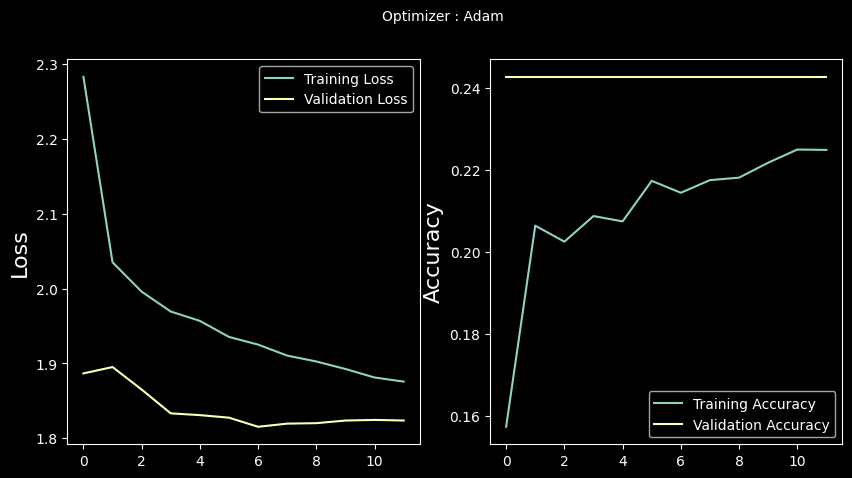

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history_7.history['loss'], label='Training Loss')
plt.plot(history_7.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_7.history['accuracy'], label='Training Accuracy')
plt.plot(history_7.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
best_model = load_model('best_model.keras')


In [ ]:
model = tuner.hypermodel.build(best_hps)


In [ ]:
model = tuner.hypermodel.build(best_hps)


In [ ]:
history = model.fit(img_train,
                    epochs=best_hps.get('epochs', 50),  # Default to 50 epochs if not specified
                    validation_data=val_set,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


The third best model was really not that good and will not be evaluated in the last section.

# MODEL EVALUATION

The best model that have been trained in this study do not show a big differences in their accuracy on the validation set. Some of the models did show signs of overfitting on the training data, like the baseline model that were trained with the oversampled dataset. <br>
In this last model evaluation then a selection of the models will be evaluated on the the test set and the best model will be used as the face expression classifier in the main.py file. <br><br> The models to be evaluated in this section are: <br>
model_1: baseline model <br>
model_2: baseline model with rescaling and augumentation layer <br>
model_4: model_2 trained on the oversampled dataset <br>
model_5: the best model found in the tuner search<br>
<br>
model_3 showed signs of overfitting the training data and will be left out. The performance of the second and third best model from the tuner search were not satisfying and will be left out.

In [4]:
# Load the saved models
model_1 = load_model('drive/MyDrive/Colab Notebooks/model_1.keras')
model_2 = load_model('drive/MyDrive/Colab Notebooks/model_2.keras')
model_4 = load_model('drive/MyDrive/Colab Notebooks/model_4.keras')
model_5 = load_model('drive/MyDrive/Colab Notebooks/model_5.keras')


In [ ]:
# Evaluate the models on the test set and inspecting the accuracy metric
def evaluate_model(model, test_set):
    result = model.evaluate(test_set)
    loss, accuracy = result[0], result[1]
    print(f'Model accuracy: {accuracy:.4f}')
    return accuracy

print("Evaluating Model 1:")
accuracy_1 = evaluate_model(model_1, test_set)
print("Evaluating Model 2:")
accuracy_2 = evaluate_model(model_2, test_set)
print("Evaluating Model 4:")
accuracy_4 = evaluate_model(model_4, test_set)
print("Evaluating Model 5:")
accuracy_5 = evaluate_model(model_5, test_set)

print(f'Model 1 Accuracy: {accuracy_1:.4f}')
print(f'Model 2 Accuracy: {accuracy_2:.4f}')
print(f'Model 4 Accuracy: {accuracy_4:.4f}')
print(f'Model 5 Accuracy: {accuracy_5:.4f}')

Evaluating Model 1:
56/56 [==============================] - 1s 8ms/step - loss: 1.1133 - accuracy: 0.5819
Model accuracy: 0.5819
Evaluating Model 2:
56/56 [==============================] - 0s 8ms/step - loss: 1.1488 - accuracy: 0.5621
Model accuracy: 0.5621
Evaluating Model 4:
56/56 [==============================] - 0s 8ms/step - loss: 1.1884 - accuracy: 0.5408
Model accuracy: 0.5408
Evaluating Model 5:
56/56 [==============================] - 1s 12ms/step - loss: 1.1999 - accuracy: 0.5395
Model accuracy: 0.5395
Model 1 Accuracy: 0.5819
Model 2 Accuracy: 0.5621
Model 4 Accuracy: 0.5408
Model 5 Accuracy: 0.5395


When examining the accuracy on the test set, it appears that the baseline model performs the best, followed by the model with the rescaling and image augmentation layers. Below, we will look deeper into the performance of these two models on the test set to gain further insights.

In [13]:
# Redirect standard output to silence the model.predict progress messages
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = io.StringIO()

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout

In [14]:
# Compute confusion matrix and classification report for model_1

true_labels = []
predicted_labels_1 = []

# Iterate over the dataset to collect true labels and predicted labels
for images, labels in test_set:
    true_labels.extend(np.argmax(labels, axis=1))
    with HiddenPrints():
        predictions = model_1.predict(images)
    predicted_labels_1.extend(np.argmax(predictions, axis=1))

true_labels = np.array(true_labels)
predicted_labels_1 = np.array(predicted_labels_1)

report_1 = classification_report(true_labels, predicted_labels_1, target_names=class_names)
conf_matrix_1 = confusion_matrix(true_labels, predicted_labels_1)
conf_matrix_normalized_1 = conf_matrix_1.astype('float') / conf_matrix_1.sum(axis=1)[:, np.newaxis]

In [15]:
# Compute classification report and confusion matrix for model_2

true_labels = []
predicted_labels_2 = []

# Iterate over the dataset to collect true labels and predicted labels
for images, labels in test_set:
    true_labels.extend(np.argmax(labels, axis=1))
    with HiddenPrints():
        predictions = model_2.predict(images)
    predicted_labels_2.extend(np.argmax(predictions, axis=1))

true_labels = np.array(true_labels)
predicted_labels_2 = np.array(predicted_labels_2)

report_2 = classification_report(true_labels, predicted_labels_2, target_names=class_names)
conf_matrix_2 = confusion_matrix(true_labels, predicted_labels_2)
conf_matrix_normalized_2 = conf_matrix_2.astype('float') / conf_matrix_2.sum(axis=1)[:, np.newaxis]

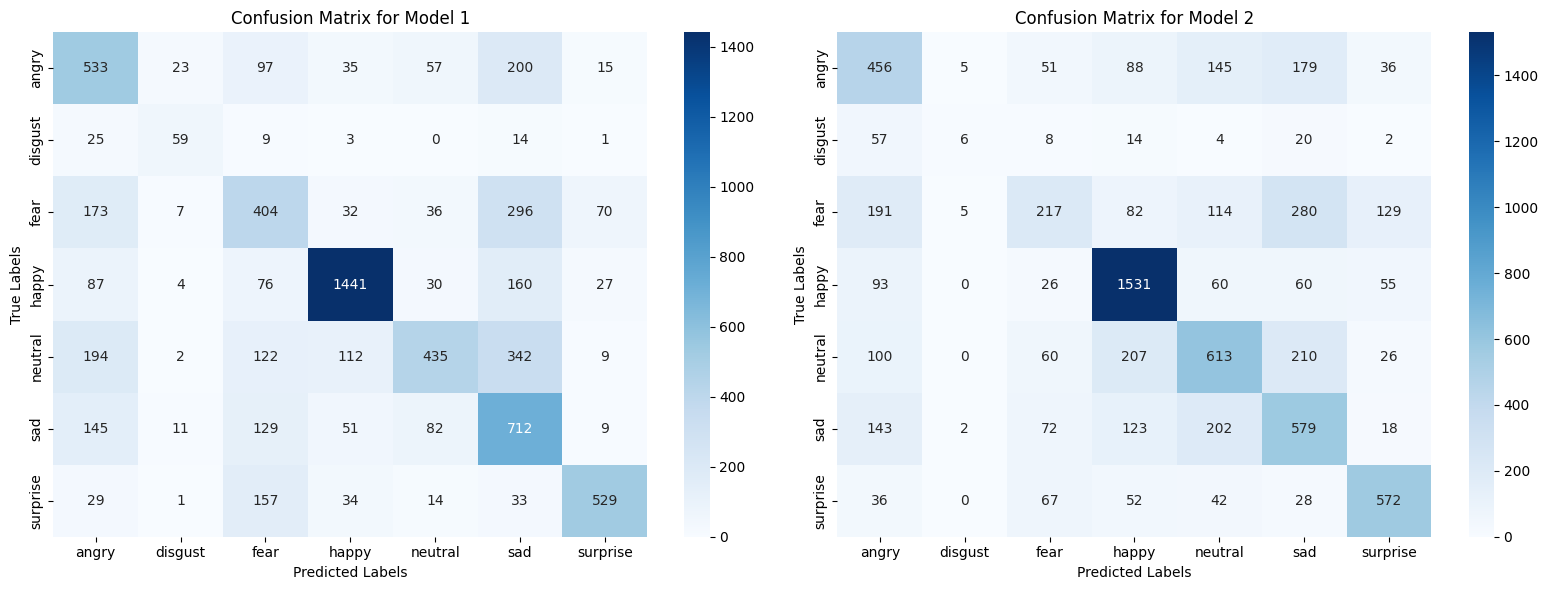

In [21]:
# Confusion matrices for model_1 and model_2

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model 1')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model 2')

plt.tight_layout()
plt.show()

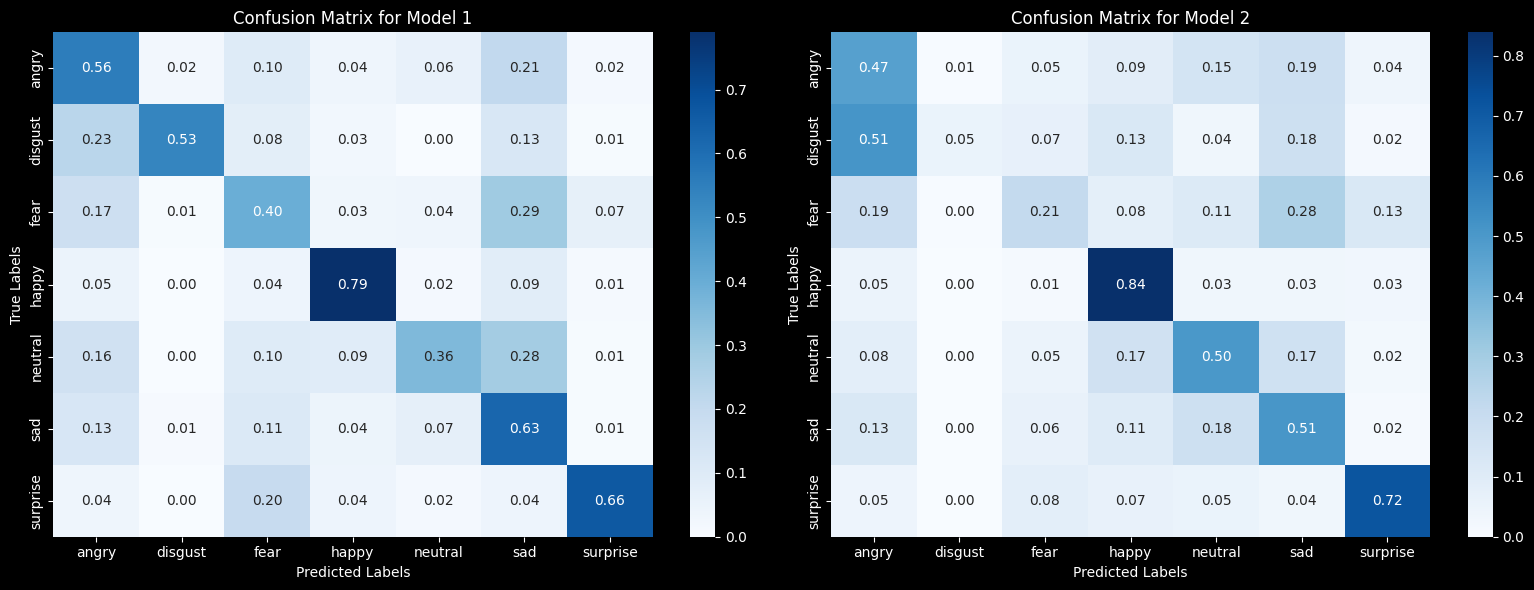

In [45]:
# Confusion matrices with recall values for model_1 and model_2

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_normalized_1, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model 1')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_normalized_2, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Model 2')

plt.tight_layout()
plt.show()

Examining the confusion matrices for the models, we observe that both perform well in predicting the 'happy' category, particularly model_2. This outcome is expected, considering it has the highest number of images, highlighting the significance of having an adequate amount of data for the model to learn from.

In model_1, we find that 23% of the 'disgust' images are misclassified as 'angry'. Model_2 encounters even greater difficulties in predicting the disgust images, often mislabeling them as angry or sad rather than disgust. Another notable difference is in predicting fear images, where model_2 tends to mistake them for a sad expression more frequently. Additionally, model_1 also has a tendency to misclassify 'fear' as 'sad', although not to the same extent as model_2. These discrepancies indicate that model_2 falls short compared to model_1 in these specific categories and that this effects the models overall accuracy.


In [46]:
print('Classification Report for model_1')
print(report_1)
print('Classification Report for model_2')
print(report_2)

Classification Report for model_1
              precision    recall  f1-score   support

       angry       0.45      0.56      0.50       960
     disgust       0.55      0.53      0.54       111
        fear       0.41      0.40      0.40      1018
       happy       0.84      0.79      0.82      1825
     neutral       0.67      0.36      0.47      1216
         sad       0.41      0.63      0.49      1139
    surprise       0.80      0.66      0.73       797

    accuracy                           0.58      7066
   macro avg       0.59      0.56      0.56      7066
weighted avg       0.62      0.58      0.59      7066

Classification Report for model_2
              precision    recall  f1-score   support

       angry       0.42      0.47      0.45       960
     disgust       0.33      0.05      0.09       111
        fear       0.43      0.21      0.29      1018
       happy       0.73      0.84      0.78      1825
     neutral       0.52      0.50      0.51      1216
         s

Inspecting the classification reports, we observe that the lowest F1 score is recorded for the 'disgust' expression images in model_2, registering only 0.09, which is quite poor. The second-worst-performing face expression is the 'fear' images. Model_1 demonstrates superior performance in F1 scores across all classes, except for the 'neutral' expression, where model_2 exhibits slightly higher scores. Overall, both the confusion matrix and the classification reports indicate that model_1 not only surpasses model_2 in overall accuracy but also in other evaluation metrics.

However, these results also suggest that some emotions are more challenging to distinguish between than others. 'Happy' is the only exclusively positive facial expression in the dataset. If we assume that there are potential similarities among positive face expressions, as well as among negative ones, then the exclusiveness of the 'Happy' images also have a positive effect on prediction of these images. Consequently, negative facial expressions are more likely to be confused with other negative expressions. A tendency that can be confirmed in our models predictions.

Despite these challenges, model_1 achieves an overall accuracy of 58% on the test set. Considering the complexity of emotion detection with 7 classes, and the quality of the data set, then this performance can be deemed acceptable.

# 10. CONCLUSIONS

The study began with a baseline model, model_1. To enhance its performance, several initiatives were tested, including adding a rescaling layer, a data augmentation layer, and training the model on an oversampled dataset.

In the second section of the study, we aimed to improve model performance by conducting a tuner search on several hyperparameters. Afterward, the three best models were tested. The best model showed good performance, but the second and third models did not yield acceptable results. The tuner search was conducted on a very limited dataset to save time, which likely affected the proposed models. With more time and computational power, it would have been interesting to run the tuner search on the entire dataset.

In the end, the baseline model trained on the regular training set showed the best prediction performance of the tested models. It exhibited a tendency to overfit the training set, as observed in the loss and accuracy curves after training, but the results on the test set were the best.

There are several things that would have been interesting to test to optimize the results of a facial expression model. One is trying to resize the images so they are sharper and perhaps easier to decode. This would have increased the training time, but it might have been worth trying. Another approach would be to preprocess the images further. We observed earlier that they had very different lighting conditions, some very dark and some very bright. Adjusting this inconsistency would also have been interesting to test.

We saw that both model_1 and model_2 were good at predicting the 'happy' category, and they more often had a hard time distinguishing between the negative facial expressions. Depending on the assignment and future use of the facial expression model, this model could likely give good and sufficient predictions if it only had to predict whether the facial expressions were positive, neutral, or negative.

In the beginning, we posed the question of how much accuracy we could expect from a deep learning model trained on this dataset. As mentioned earlier, it can be challenging even for humans to decode facial expressions, and some of the images did not seem to be the best representatives for the labels they were assigned. A future initiative could be to use other similar datasets with facial expressions to increase the quality and the amount of data the model is trained on. Training with an increased dataset and using one of the many pretrained models would most likely lead to better prediction accuracies than what this study has accomplished. This would be a natural next step in the search for a better facial expression recognition classifier.


# 11. REFLECTIONS

1.	Challenges

There have been several challenges. One was deciding how and in which system to run the code. I experienced many problems with my TensorFlow environment in Anaconda and eventually decided to run everything in Colab. This has worked well. The other major challenge was improving the model. I made modifications to the model from the video, such as updating deprecated functions, but it was difficult to achieve better performance despite trying many approaches.

2.	Grade

I have reflected on and critically assessed the models and their performance as well as the dataset input. The aim has been to create a study that tests several methods for optimizing a deep learning model and presents the findings in an understandable way. I hope that the provided work will be sufficient for achieving VG.

3.	Recommendations

It would have saved me some time if I had made a plan for the study at the beginning. Instead, I tested a lot of things, and it was only in the final stages that the code became structured. While it was a good learning process to experiment with many approaches, it was not optimal in terms of time management.